In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

In [ ]:
filePath = 'data/fullTraces_200_lg_fixed.csv'

In [47]:
data = pd.read_csv(filePath, header=0)
print(f"Initial data shape: {data.shape}")
data.drop(columns=['SeqNumber', 'run'], inplace=True)
line_loading_cols = data.filter(regex="LineLoading_[0-9]+").columns
fillNaNDict = {}
for line in line_loading_cols:
    fillNaNDict[line] = 0
# Substitute LineLoading_x NaN values with 0
data = data.fillna(fillNaNDict)
# Data cleanup (nan non unique samples removal)
data = data.dropna()
print(f"Data shape after dropping NaN values: {data.shape}")
data = data.round(4)
# Remove duplicate rows
data = data.drop_duplicates()
print(f"Data shape after dropping duplicates: {data.shape}")

# Rescale "LineLoading_x" features to decimal % (just dividig by 100)
line_loading_cols = data.filter(regex="LineLoading_[0-9]+").columns
data[line_loading_cols] = data[line_loading_cols].div(100)

# Add a new feature "PercOverLines" as the percentage of overloaded lines (computed based on LineLoading_x > 100)
data['PercOverloadedLines'] = (data.filter(regex="LineLoading_[0-9]+", axis=1) > 1).sum(axis=1) / data.filter(regex="LineLoading_[0-9]+", axis=1).shape[1]
# Add a new feature "PercOutOfSpecBusses" as the percentage of out-of-spec busses (computed based on BusVoltage_x < 0.95 or BusVoltage_x > 1.05)
data['PercOutOfSpecBusses'] = (data.filter(regex="BusVoltage_[0-9]+", axis=1).lt(0.95) | data.filter(regex="BusVoltage_[0-9]+", axis=1).gt(1.05)).sum(axis=1) / data.filter(regex="BusVoltage_[0-9]+", axis=1).shape[1]
# Add a new feature "PercFullyDisconnectedLines" as the percentage of fully disconnected lines (computed based on LineLoading_x == 0)
data['PercFullyDisconnectedLines'] = (data.filter(regex="LineLoading_[0-9]+", axis=1) == 0).sum(axis=1) / data.filter(regex="LineLoading_[0-9]+", axis=1).shape[1]

data.head()

Initial data shape: (4000, 62)
Data shape after dropping NaN values: (4000, 60)
Data shape after dropping duplicates: (4000, 60)


,BusVoltage_0,BusVoltage_1,BusVoltage_10,BusVoltage_11,BusVoltage_12,BusVoltage_13,BusVoltage_14,BusVoltage_2,BusVoltage_3,BusVoltage_4,...,NumCycles,PercNodesInCycles,MeanCycleLength,MaxCycleLength,MinCycleLength,Load,Generation,PercOverloadedLines,PercOutOfSpecBusses,PercFullyDisconnectedLines
0,1.03,1.0018,0.9802,0.9801,1.0058,1.0026,1.0008,0.994,0.9813,0.9798,...,0,0.0,0.0,0,0,0.93,1.17,0.0,0.0,0.0
1,1.03,1.0018,0.9802,0.9801,1.0058,1.0026,1.0008,0.994,0.9813,0.9798,...,0,0.0,0.0,0,0,0.93,1.17,0.0,0.0,0.0
2,1.03,1.0018,0.9802,0.9801,1.0058,1.0026,1.0008,0.994,0.9813,0.9798,...,0,0.0,0.0,0,0,0.93,1.17,0.0,0.0,0.0
3,1.03,1.0018,0.9803,0.9801,1.0058,1.0026,1.0008,0.994,0.9813,0.9798,...,0,0.0,0.0,0,0,0.93,1.17,0.0,0.0,0.0
4,1.03,1.0018,0.9803,0.9801,1.0058,1.0026,1.0008,0.994,0.9813,0.9798,...,0,0.0,0.0,0,0,0.93,1.17,0.0,0.0,0.0


Text(0.5, 1.0, 'LineLoading_x Distribution')

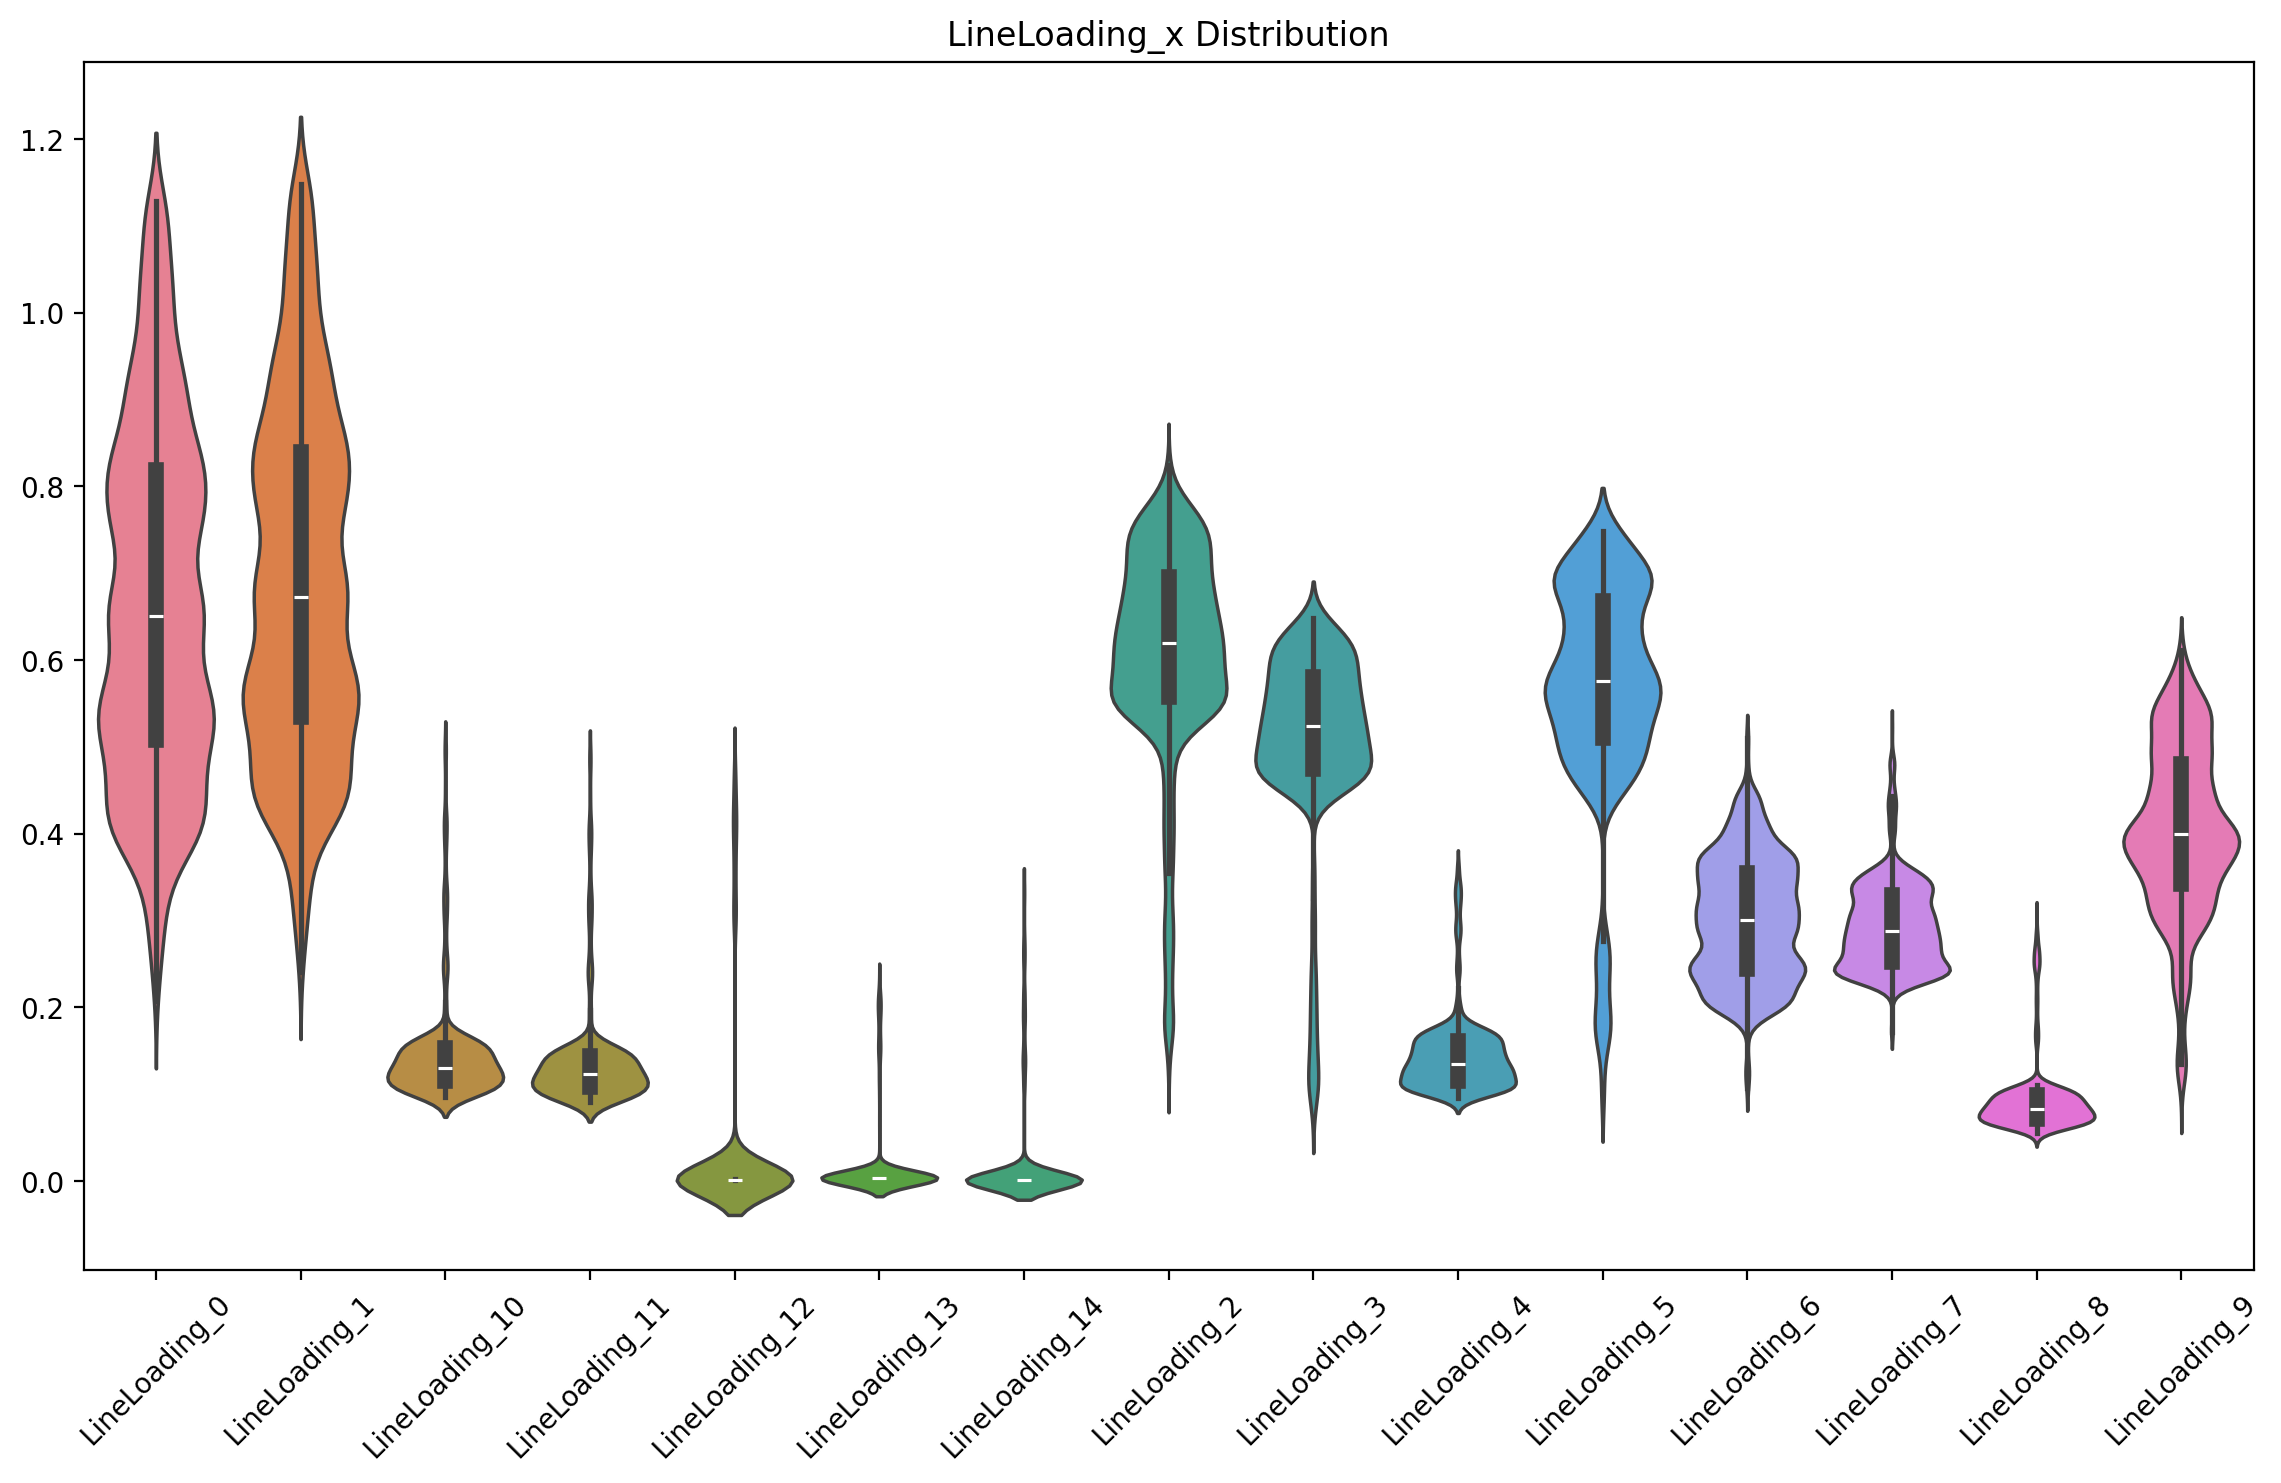

In [49]:
plt.figure(figsize=(14, 8))
sns.violinplot(data=data.filter(regex="LineLoading_[0-9]+"))
plt.xticks(rotation=45)
plt.title("LineLoading_x Distribution")

Text(0.5, 1.0, 'BusVoltage_x Distribution')

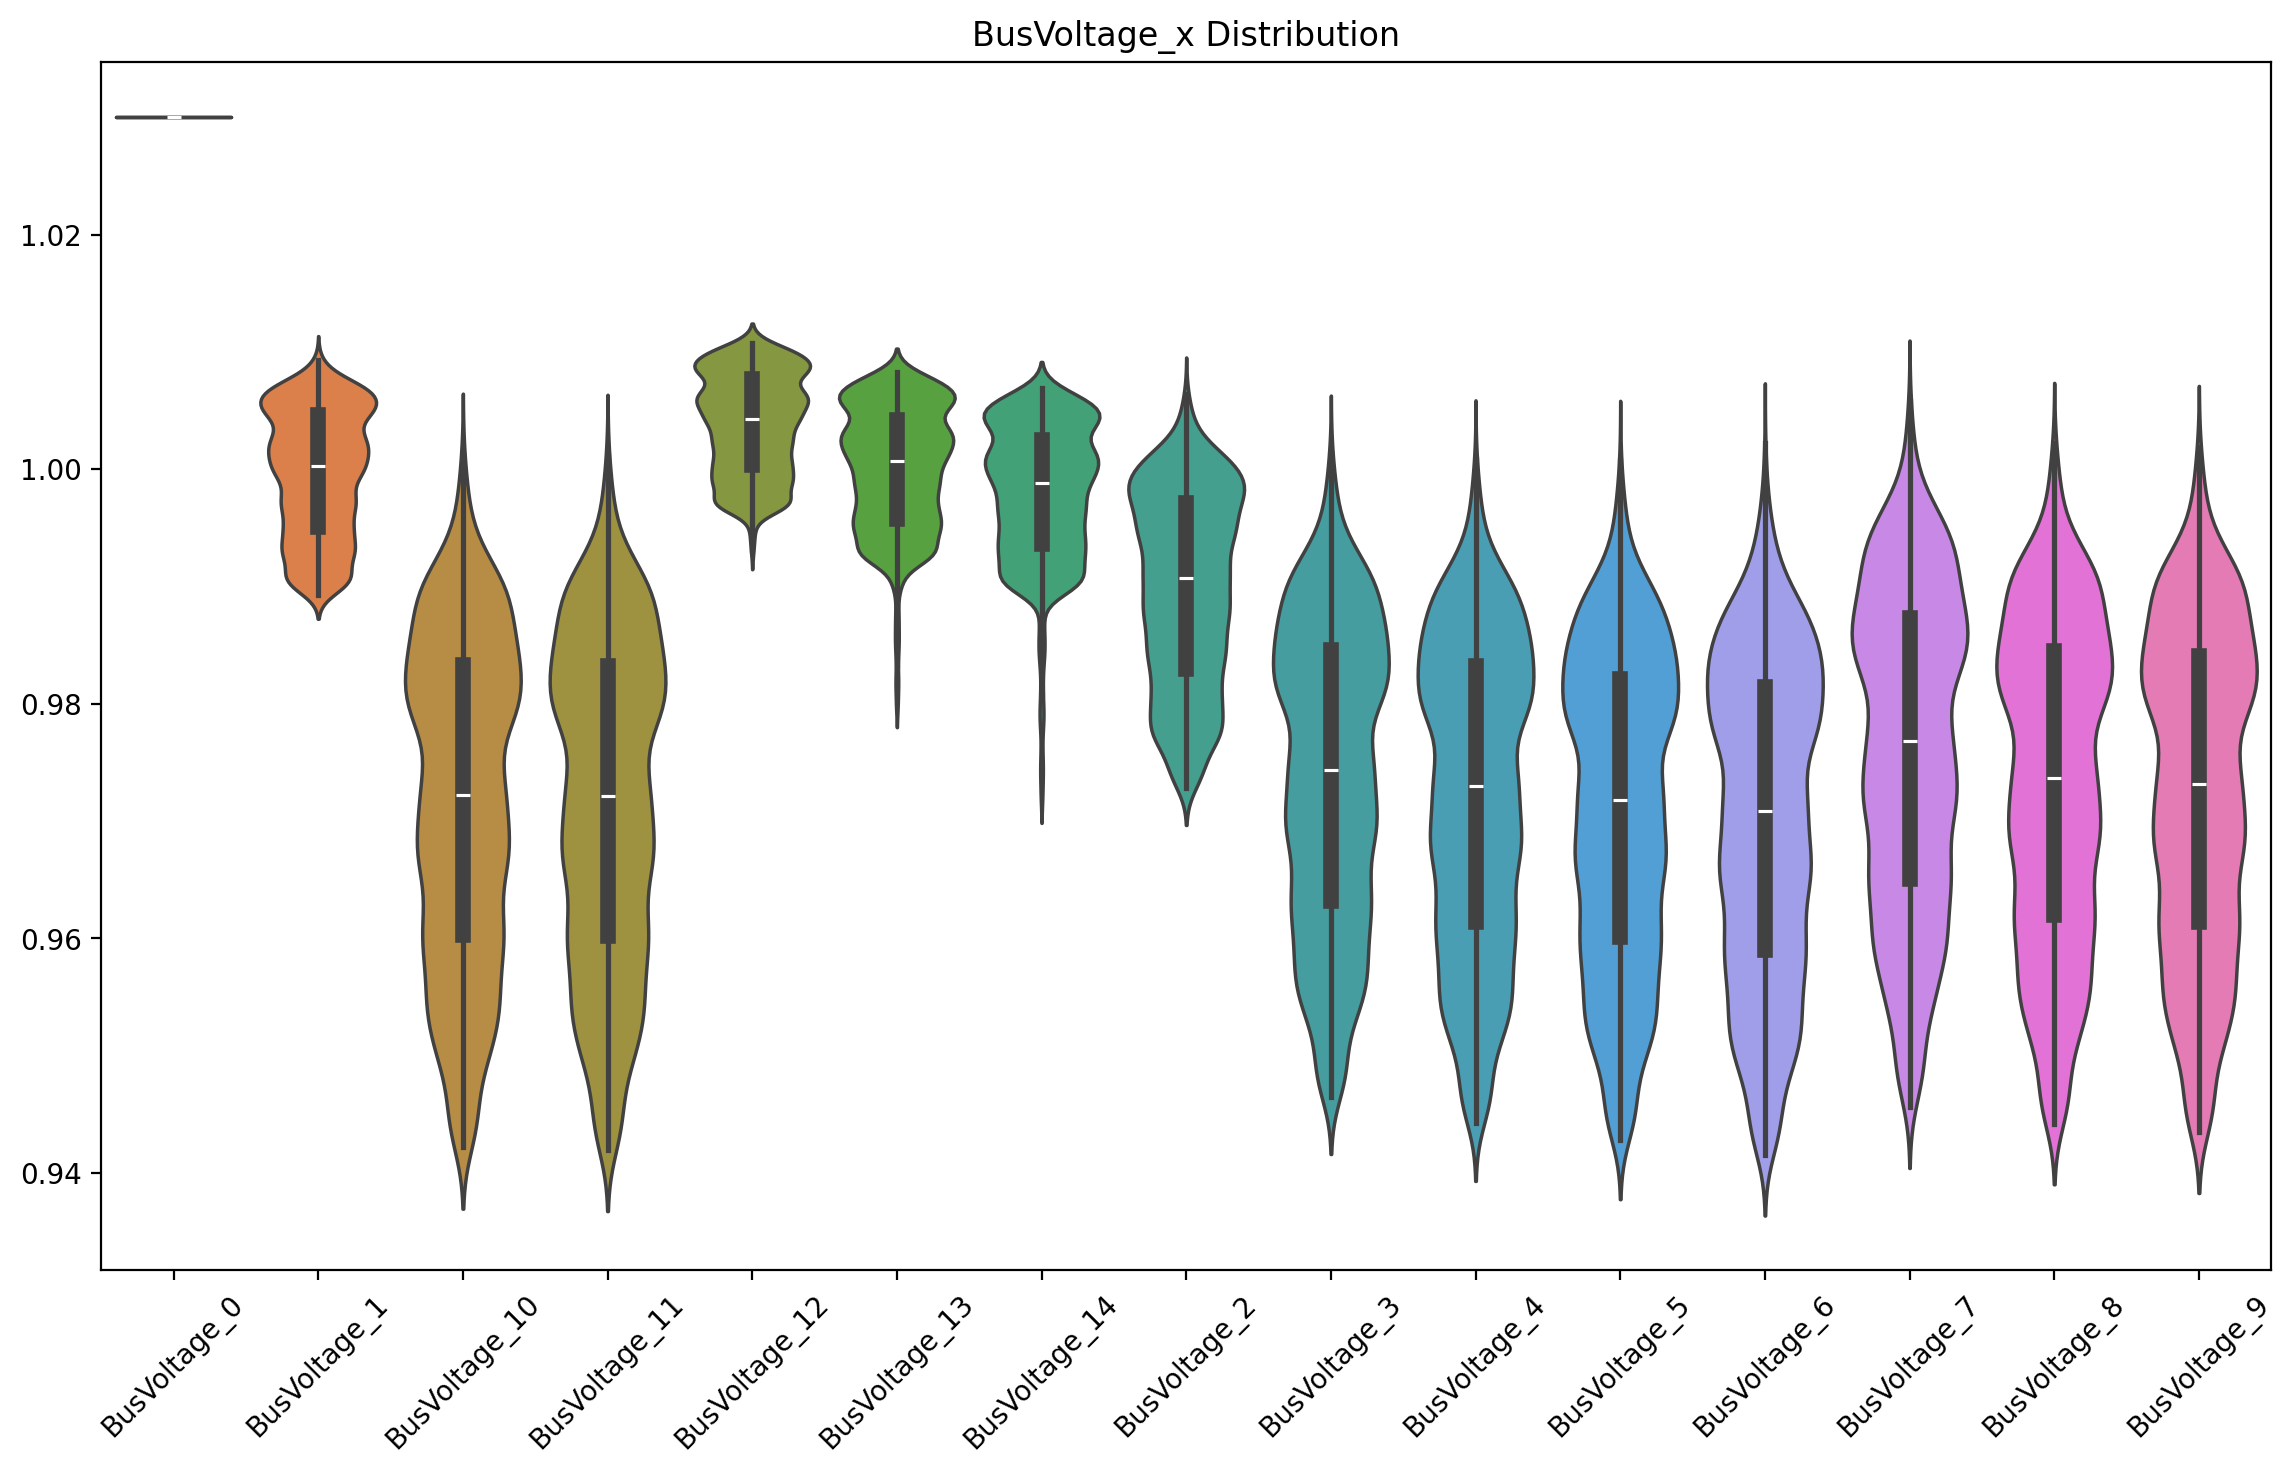

In [48]:
plt.figure(figsize=(14, 8))
sns.violinplot(data=data.filter(regex="BusVoltage_[0-9]+"))
plt.xticks(rotation=45)
plt.title("BusVoltage_x Distribution")

/tmp/ipykernel_3944530/517862598.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


<Figure size 3200x1600 with 0 Axes>

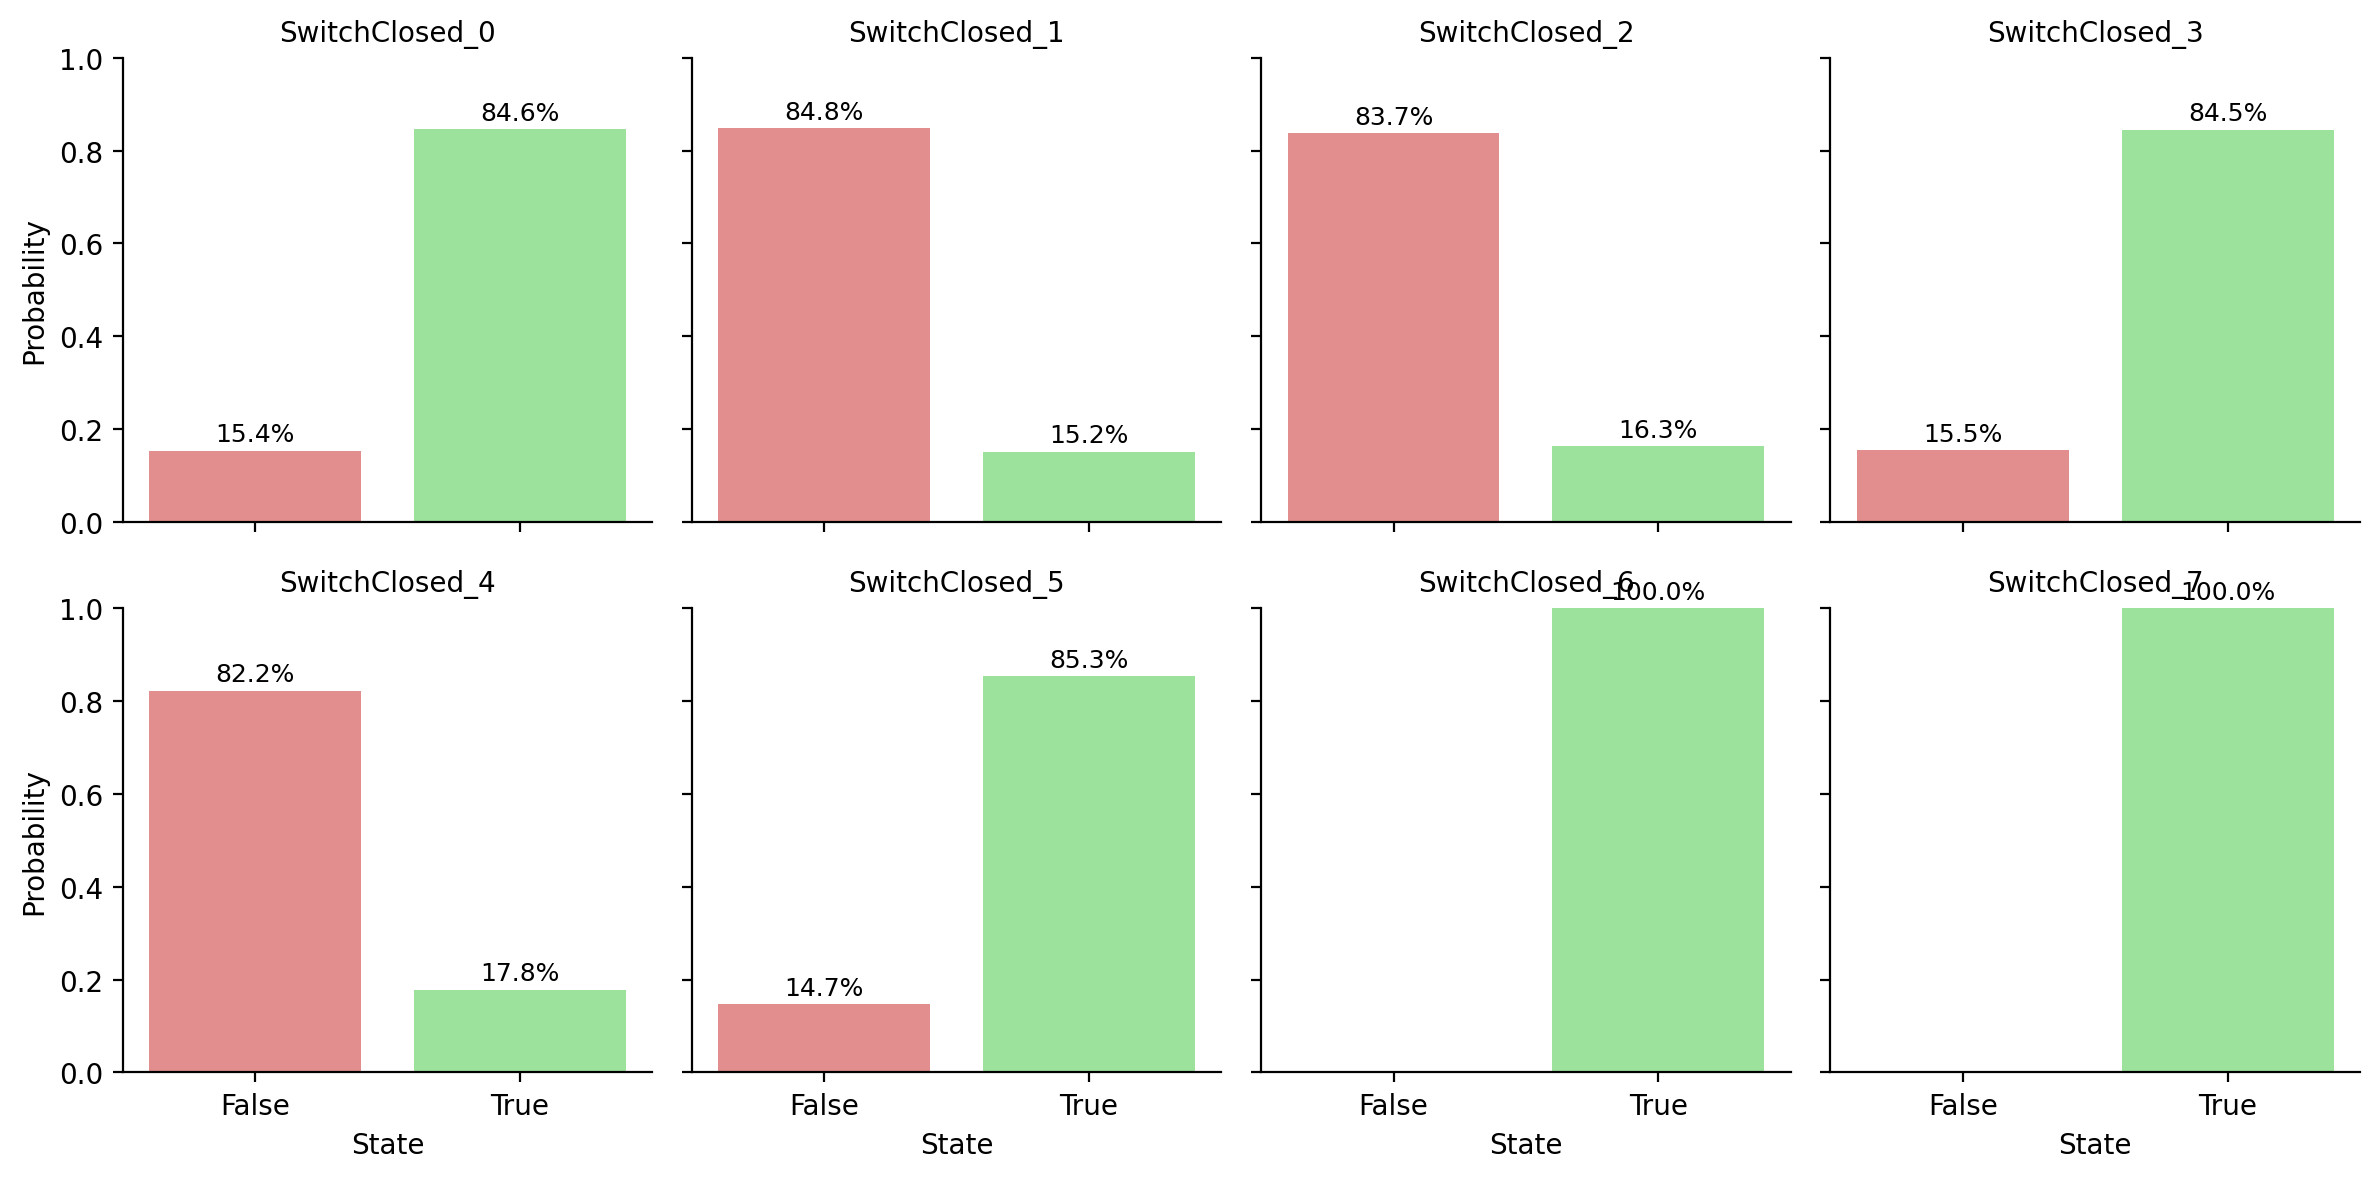

In [58]:
plt.figure(figsize=(16, 8))
switch_cols = data.filter(regex="SwitchClosed_[0-9]+").columns

switch_long = pd.melt(
    data[switch_cols], 
    var_name="Switch", 
    value_name="Closed"
)

# Calcola la probabilità per ciascuno stato di ogni switch
switch_prob = switch_long.groupby(['Switch', 'Closed']).size().reset_index(name='count')
total_counts = switch_long.groupby('Switch').size().reset_index(name='total')
switch_prob = pd.merge(switch_prob, total_counts, on='Switch')
switch_prob['probability'] = switch_prob['count'] / switch_prob['total']

g = sns.catplot(
    data=switch_prob, 
    x="Closed", 
    y="probability",
    col="Switch", 
    kind="bar", 
    col_wrap=4, 
    height=3,
    palette=["lightcoral", "lightgreen"],
    sharex=True,
    sharey=True
)

g.set(ylim=(0, 1))

# Aggiungi etichette percentuali alle barre
for ax in g.axes:
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width()/2.,
            height + 0.02,
            f'{height:.1%}',
            ha="center", fontsize=9
        )

g.set_axis_labels("State", "Probability")
g.set_titles("{col_name}")
plt.tight_layout()

/tmp/ipykernel_3944530/68673742.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/tmp/ipykernel_3944530/68673742.py:14: UserWarning: The palette list has more values (15) than needed (6), which may not be intended.
  g = sns.catplot(


<Figure size 2800x1600 with 0 Axes>

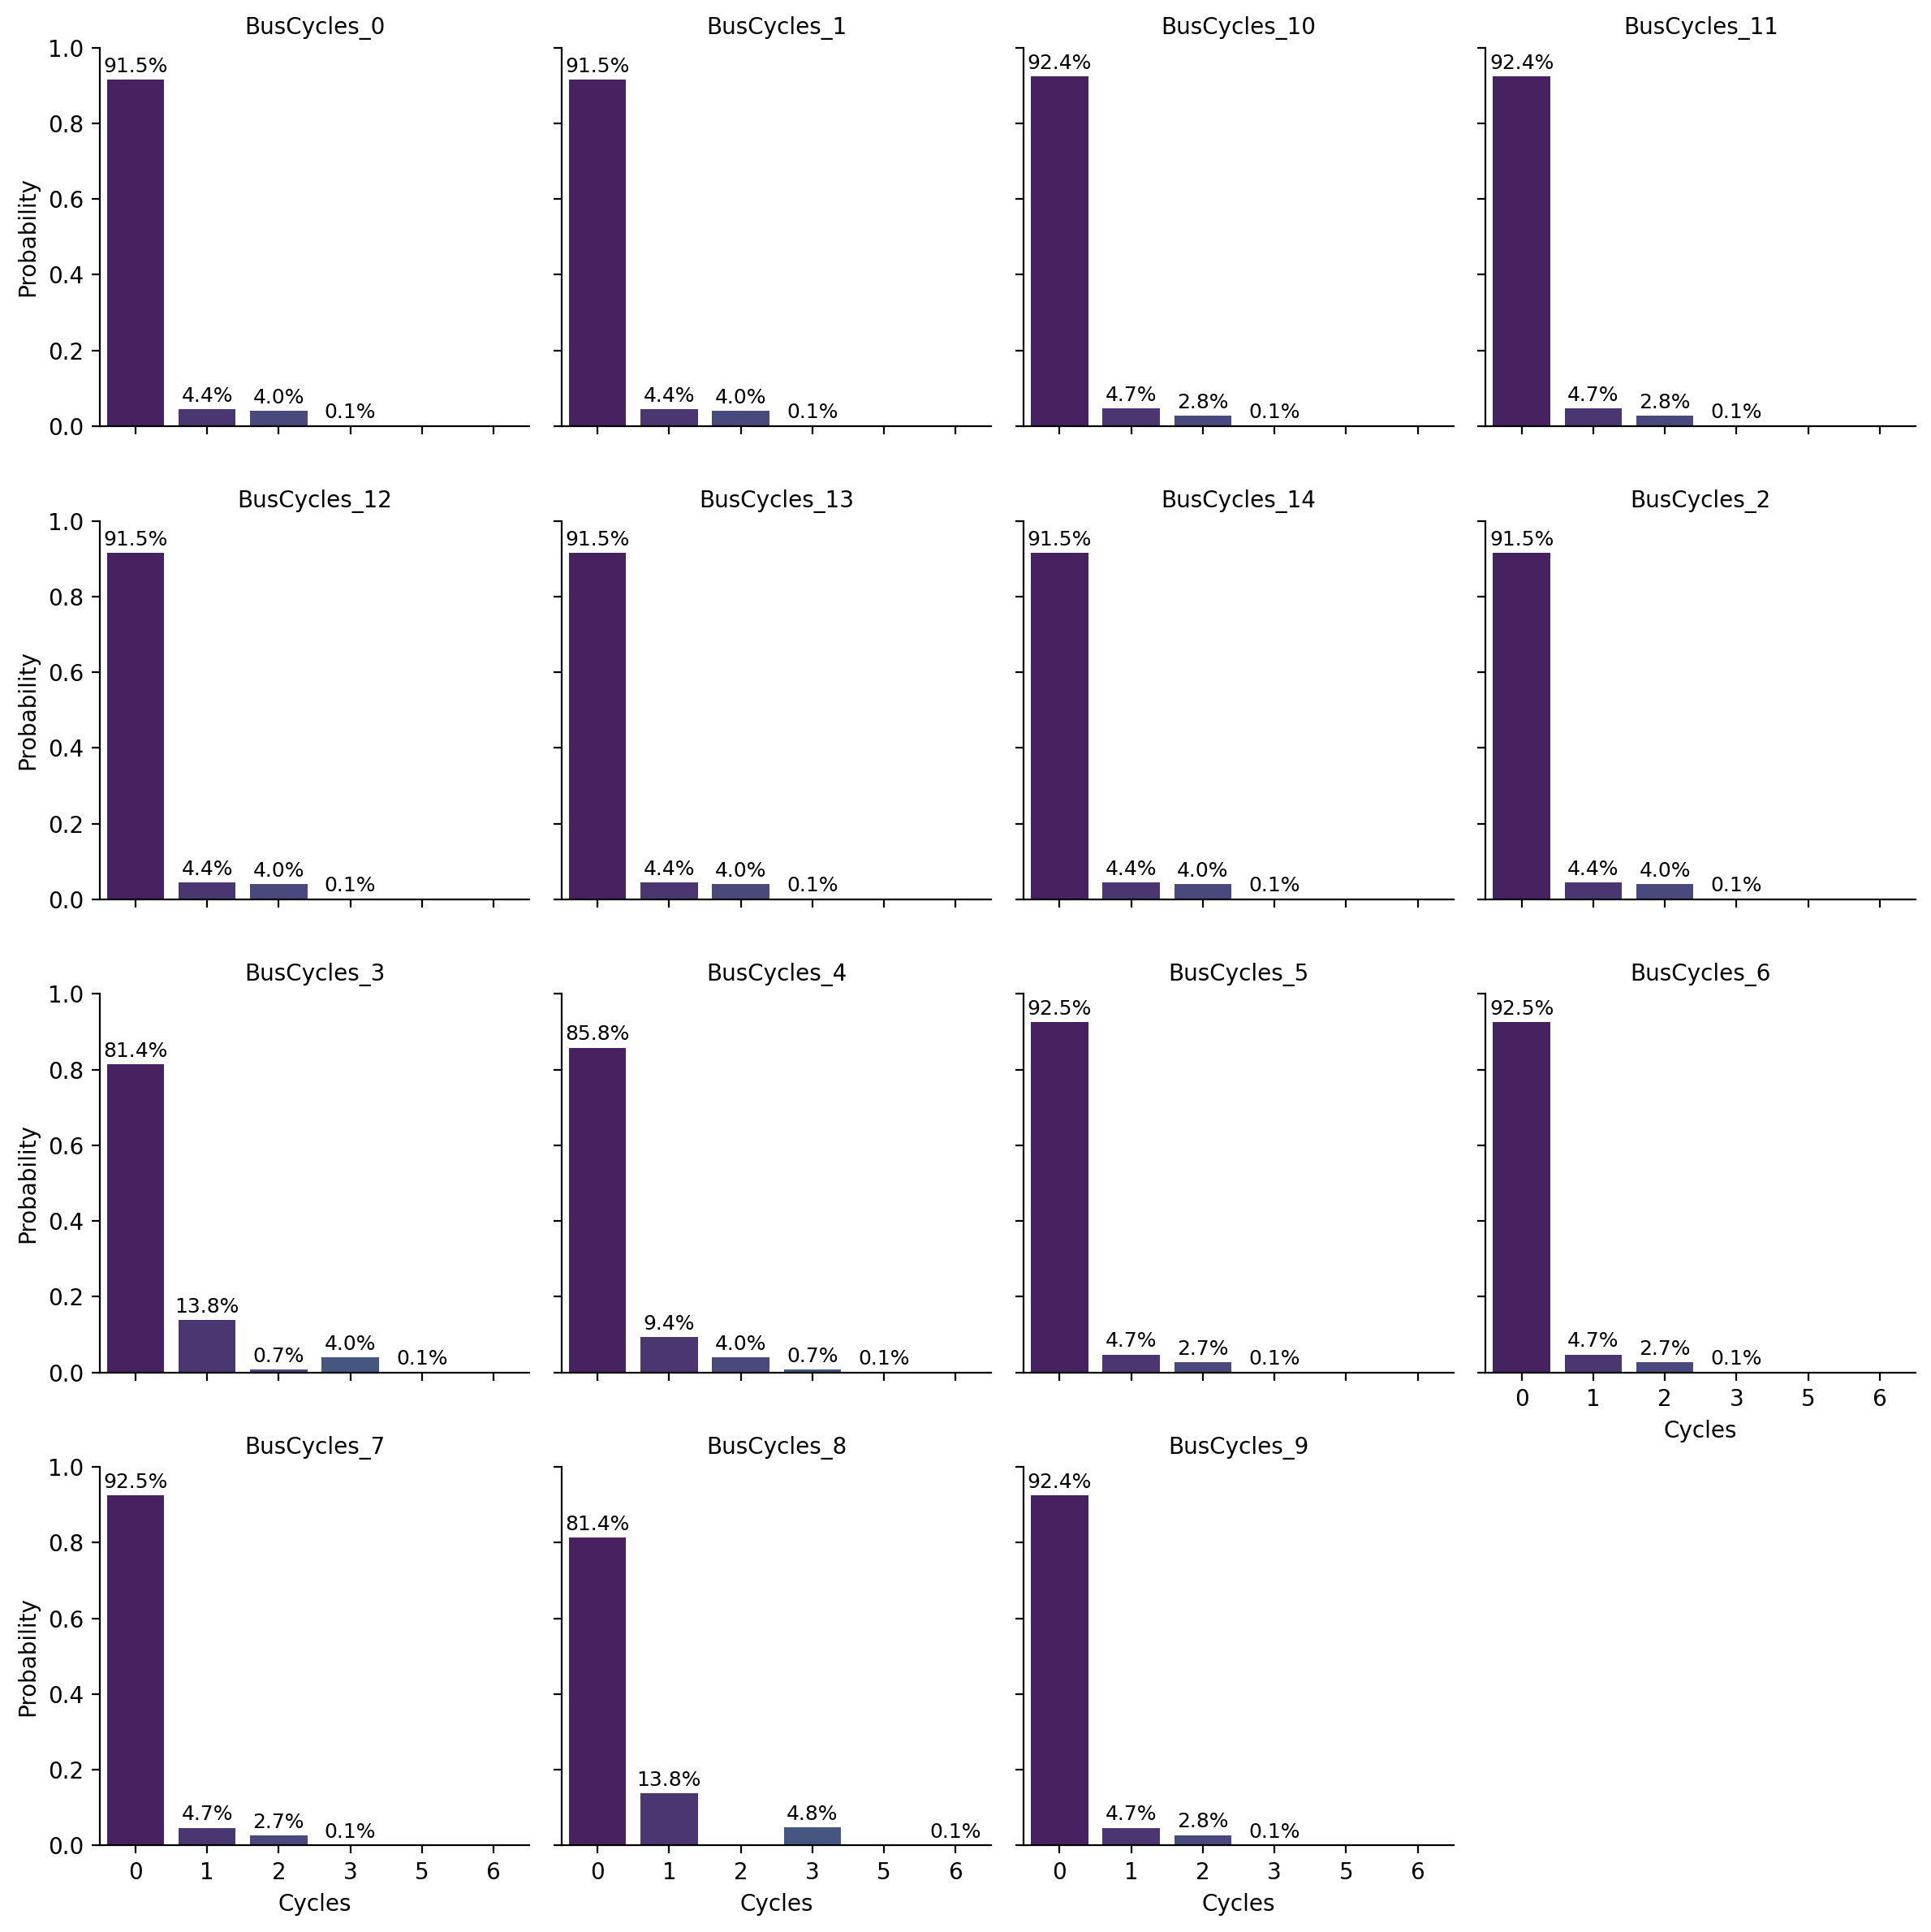

In [62]:
plt.figure(figsize=(14, 8))
bus_cycles_cols = data.filter(regex="BusCycles_[0-9]+").columns
bus_cycles_long = pd.melt(
    data[bus_cycles_cols],
    var_name="Bus",
    value_name="Cycles"
)

# Calcola la probabilità per ciascun numero di cicli di ogni bus
bus_cycles_prob = bus_cycles_long.groupby(['Bus', 'Cycles']).size().reset_index(name='count')
total_counts = bus_cycles_long.groupby('Bus').size().reset_index(name='total')
bus_cycles_prob = pd.merge(bus_cycles_prob, total_counts, on='Bus')
bus_cycles_prob['probability'] = bus_cycles_prob['count'] / bus_cycles_prob['total']
g = sns.catplot(
    data=bus_cycles_prob,
    x="Cycles",
    y="probability",
    col="Bus",
    kind="bar",
    col_wrap=4,
    height=3,
    palette=sns.color_palette("viridis", n_colors=len(bus_cycles_cols)),
    sharex=True,
    sharey=True
)
g.set(ylim=(0, 1))
# Aggiungi etichette percentuali alle barre
for ax in g.axes:
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width()/2.,
            height + 0.02,
            f'{height:.1%}',
            ha="center", fontsize=9
        )
g.set_axis_labels("Cycles", "Probability")
g.set_titles("{col_name}")
plt.tight_layout()

<AxesSubplot:xlabel='Load', ylabel='Probability'>

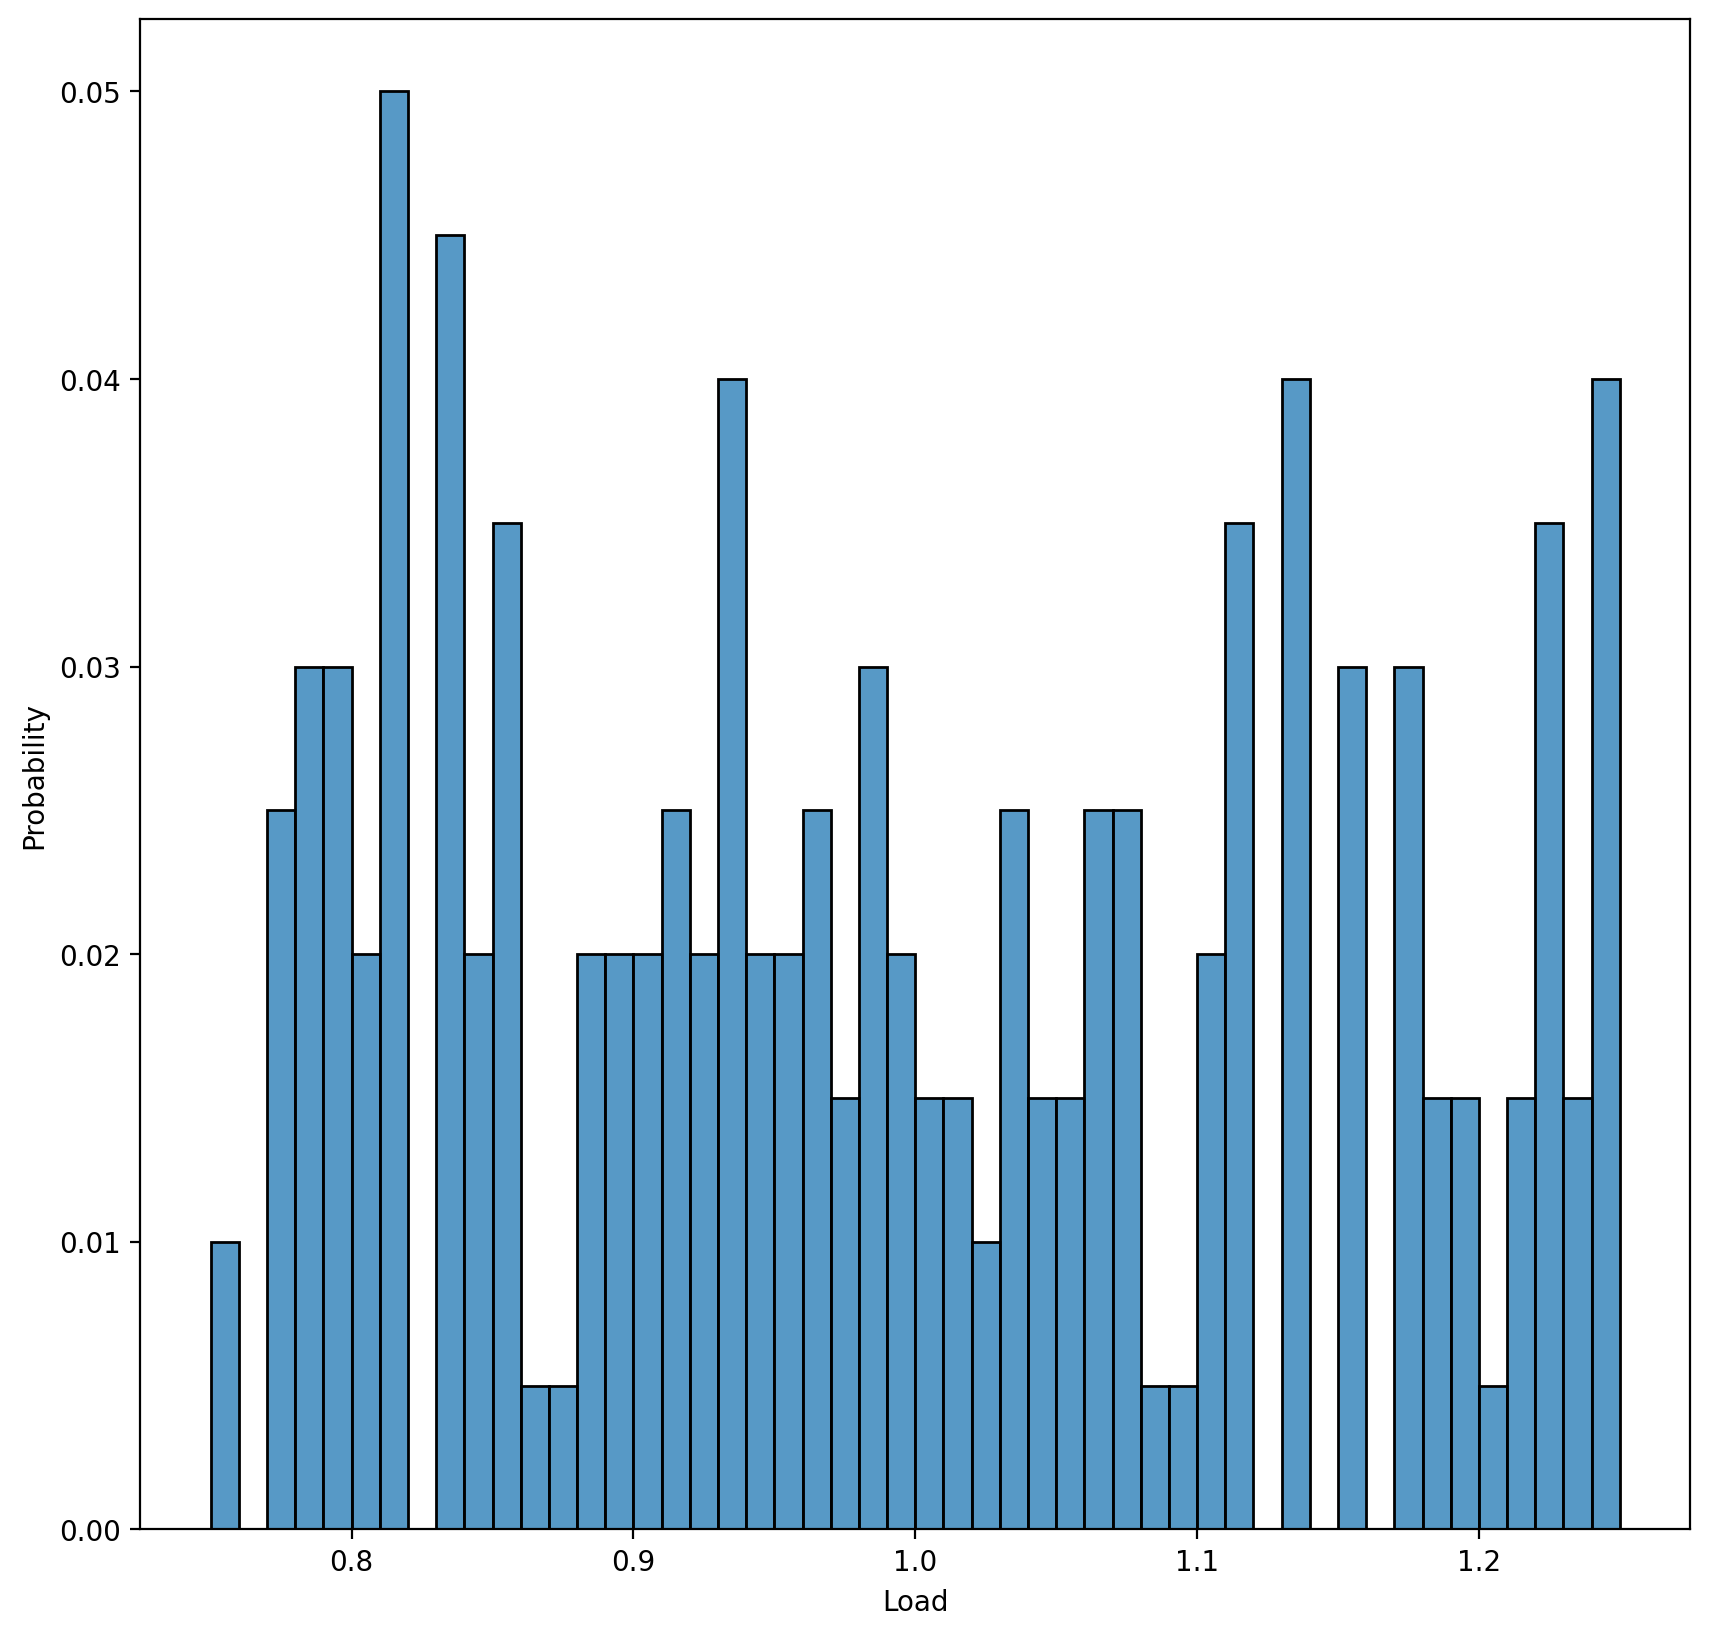

In [34]:
sns.histplot(data["Load"], stat="probability", bins=50, common_norm=False)

<AxesSubplot:xlabel='Generation', ylabel='Probability'>

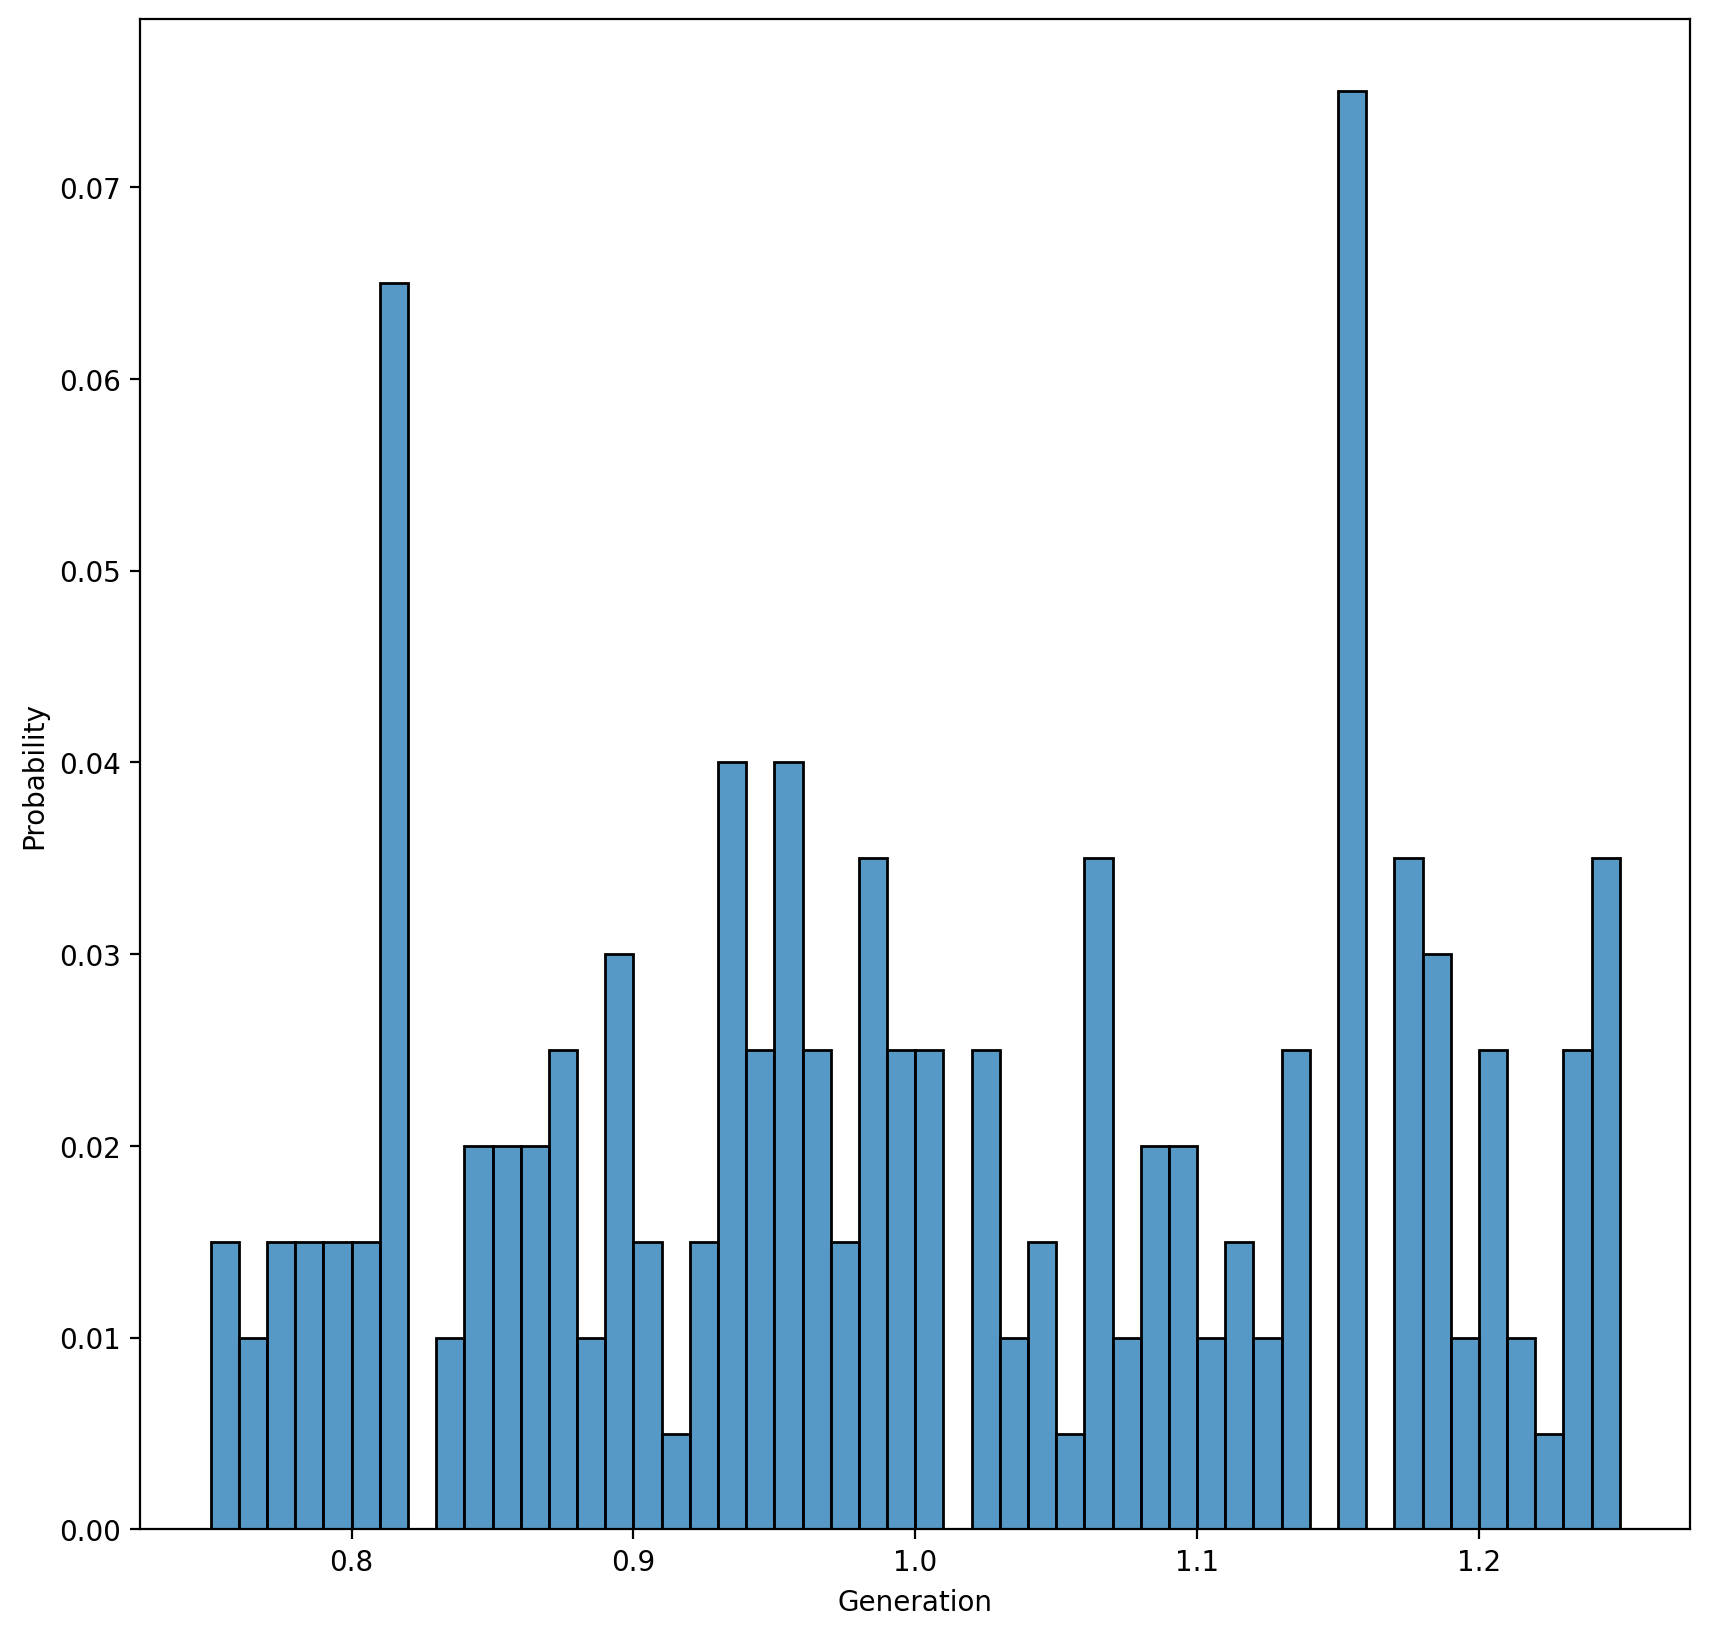

In [35]:
sns.histplot(data["Generation"], stat="probability", bins=50, common_norm=False)

<AxesSubplot:xlabel='PercFullyDisconnectedLines', ylabel='Probability'>

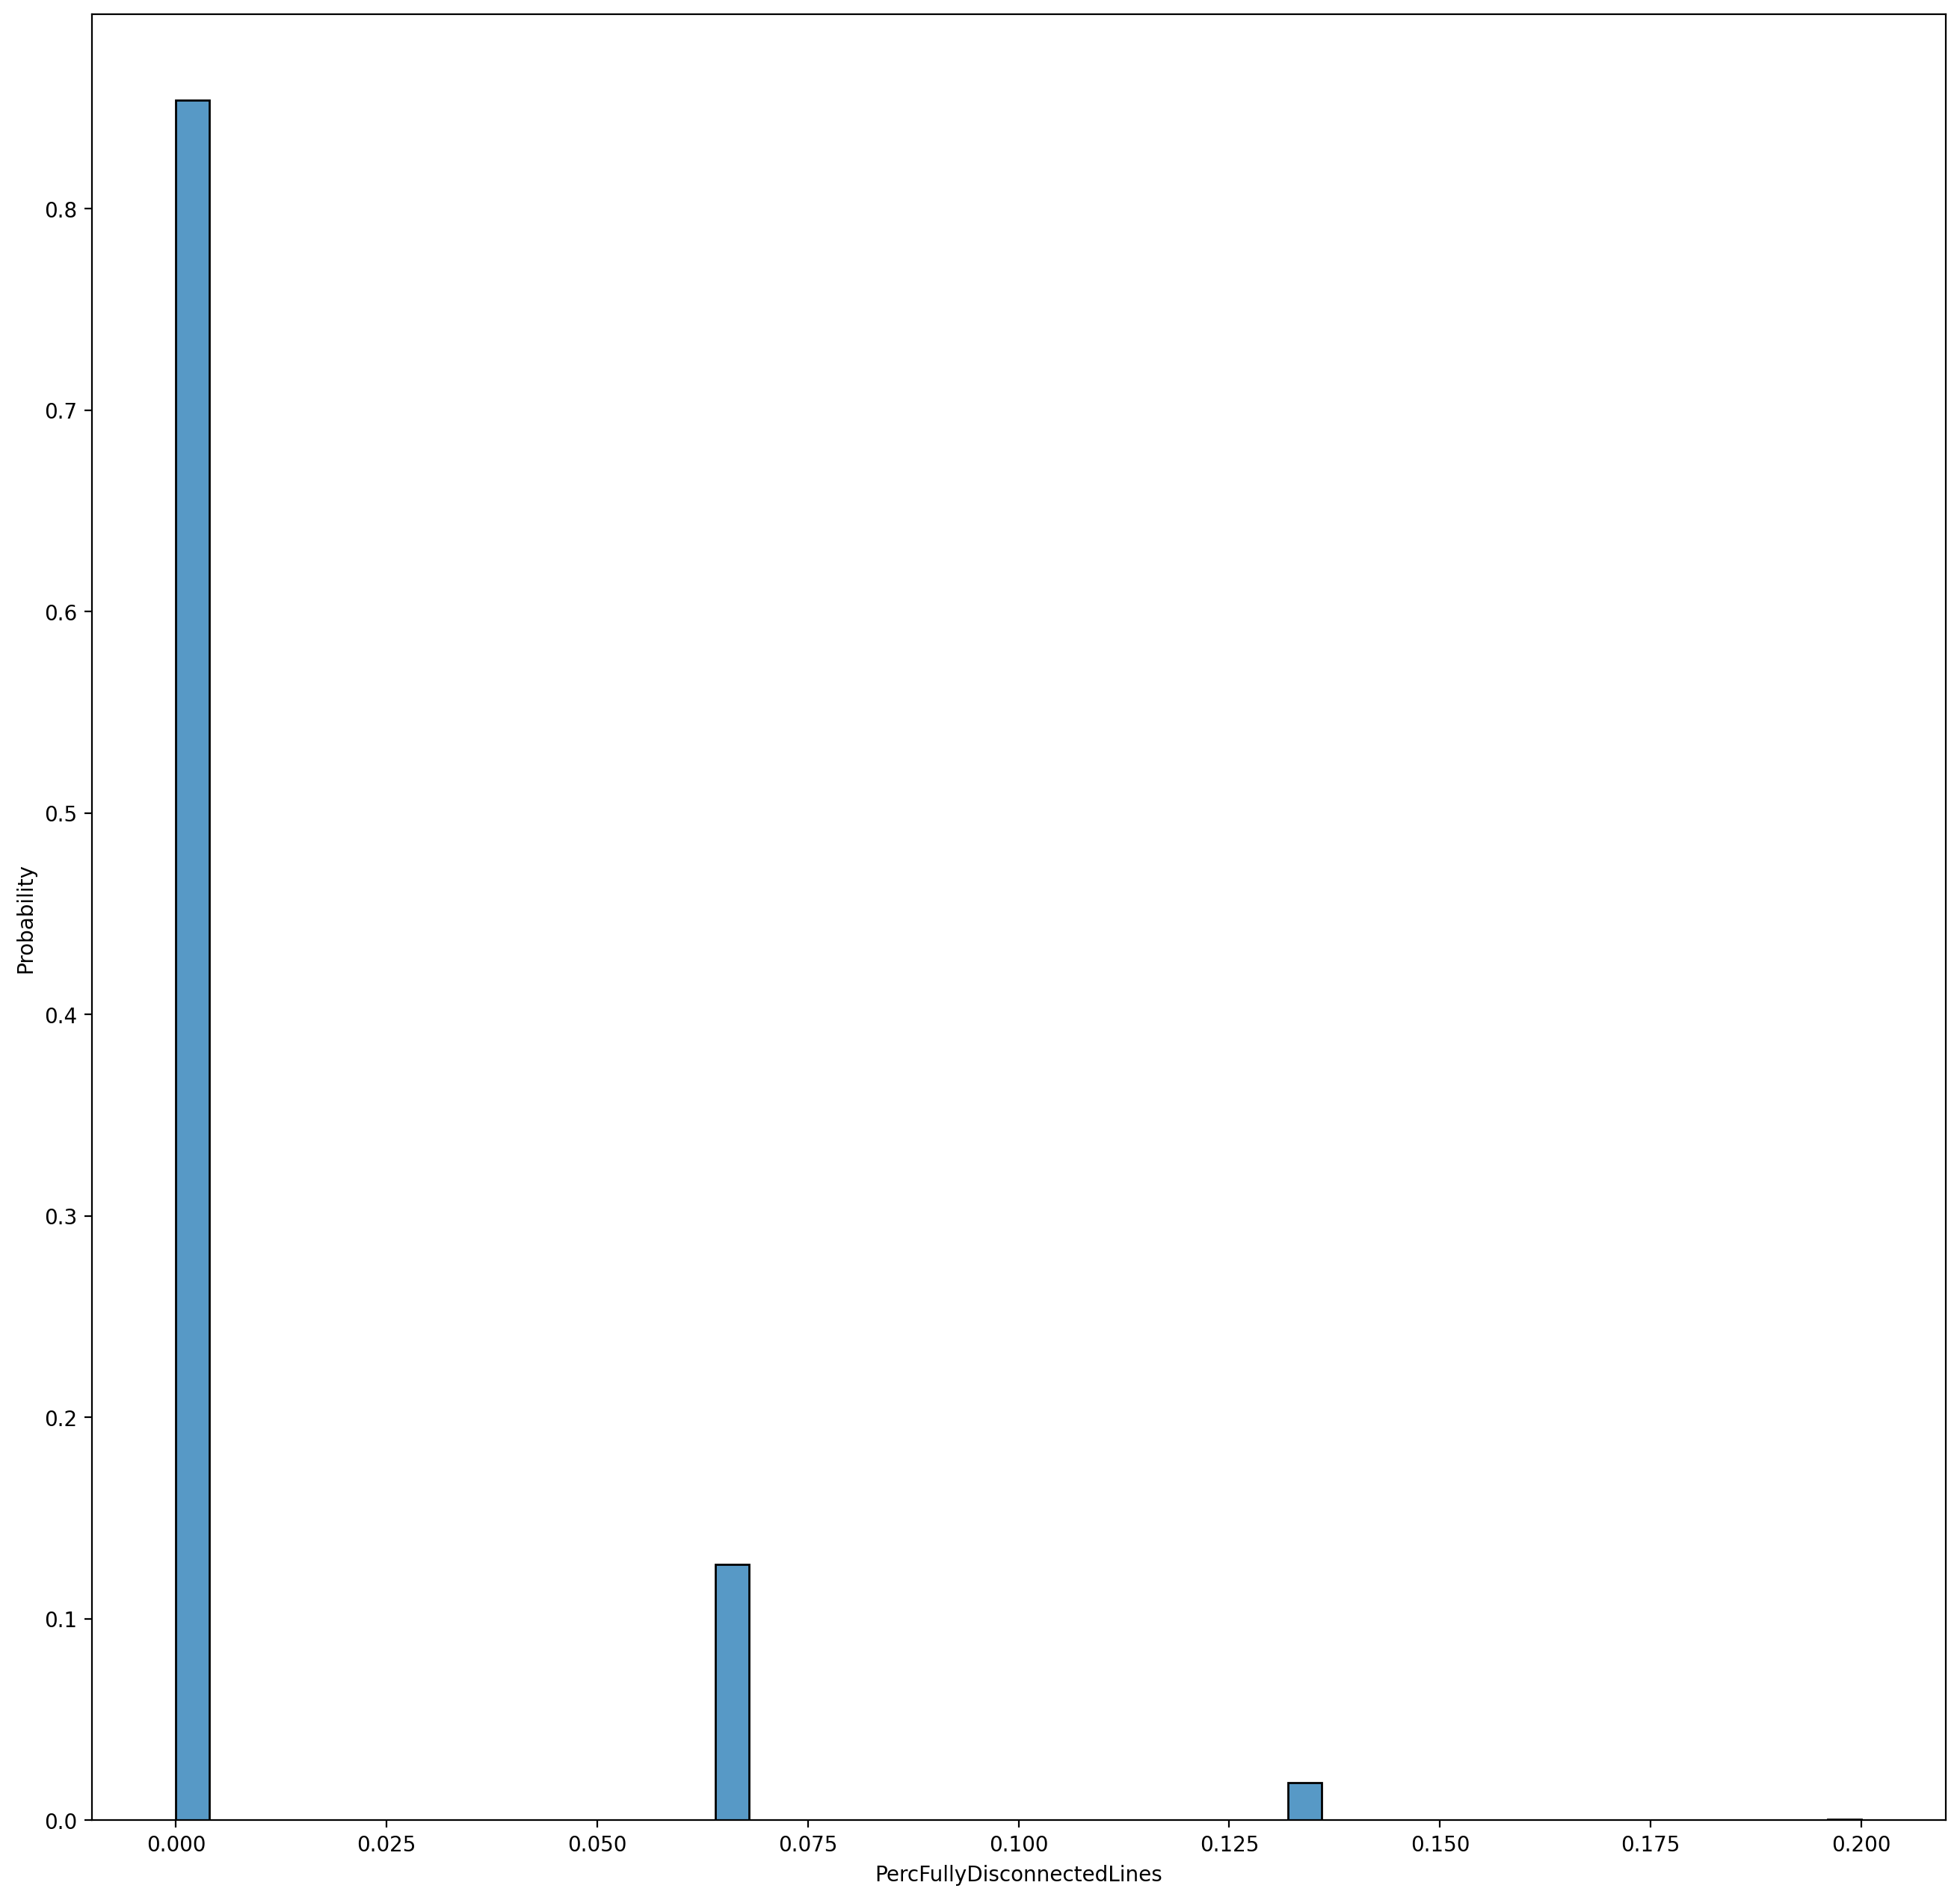

In [ ]:
# Distribution of PercOfFullyDisconnectedLines
sns.histplot(data["PercFullyDisconnectedLines"], stat="probability", bins=50, common_norm=False)

<AxesSubplot:>

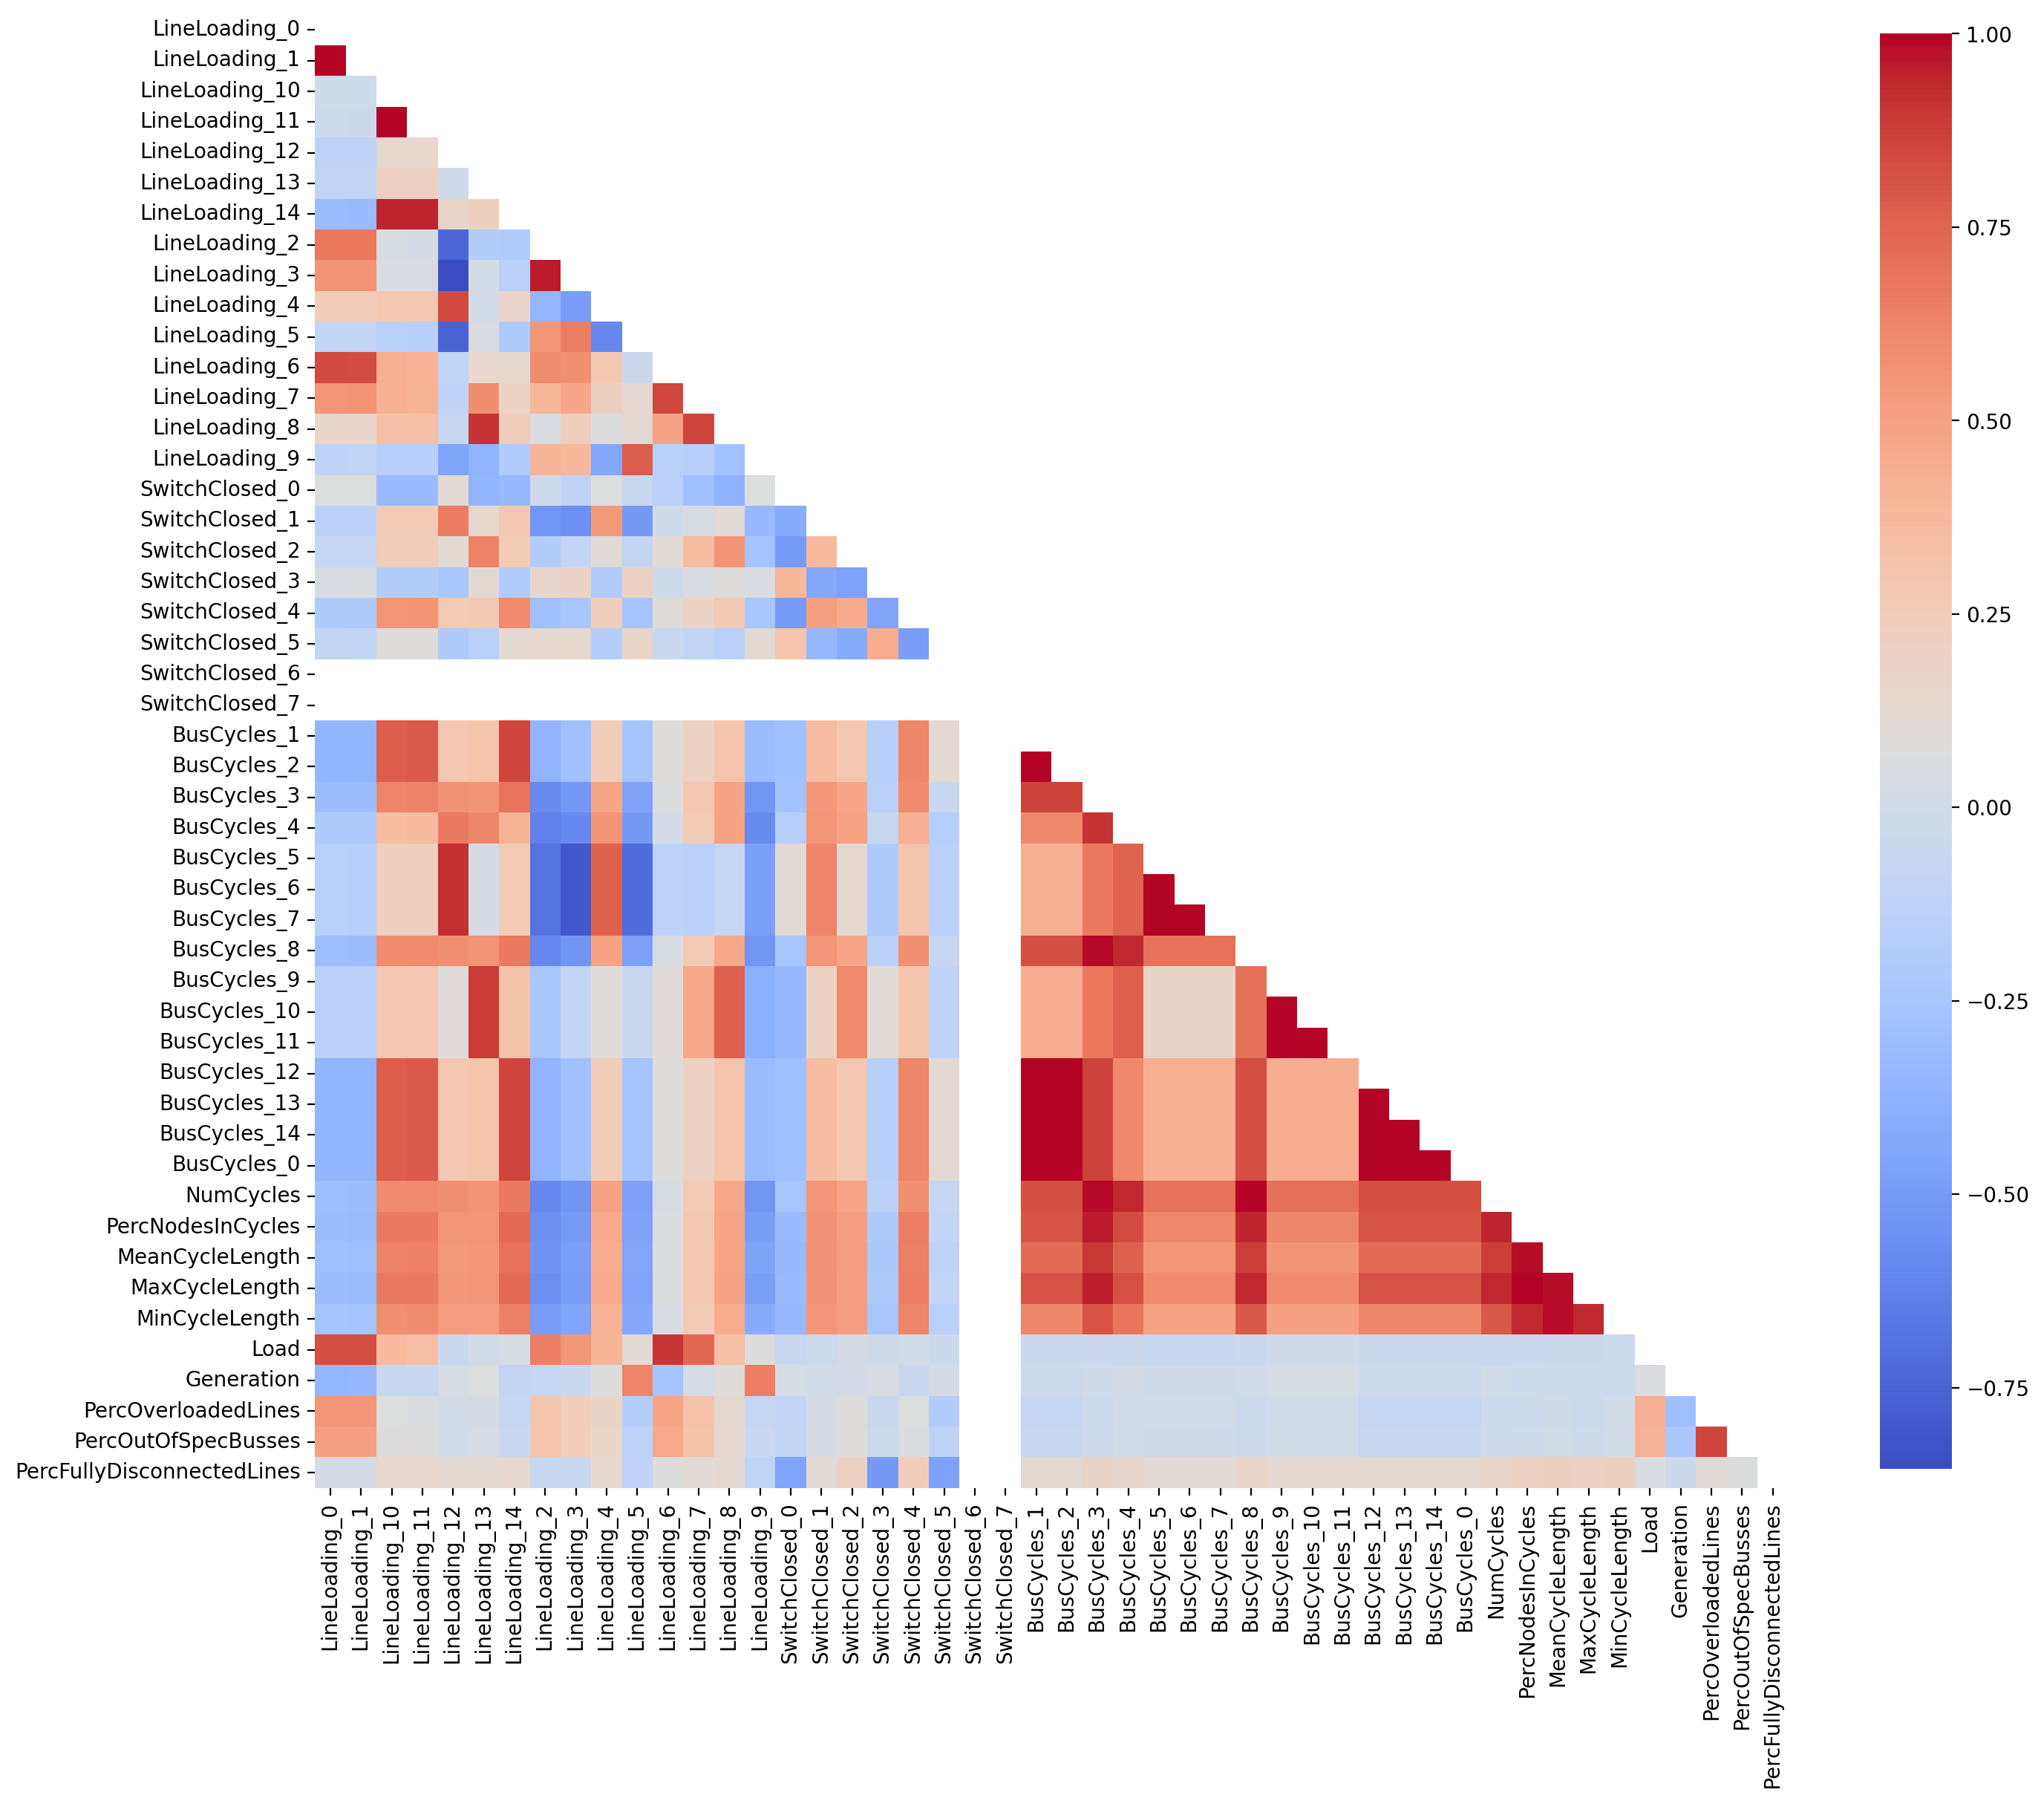

In [36]:
# Drop BusVoltage features
bus_voltage_cols = data.filter(regex="BusVoltage_[0-9]+").columns
data.drop(columns=bus_voltage_cols, inplace=True)
plt.rcParams['figure.figsize'] = [16, 16]
plt.rcParams['figure.dpi'] = 200
# Feature correlation analysis
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, mask=np.triu(corr))

In [40]:
# Perform Recursive Feature Elimination with Random Forest as backend model
minFeat = 1
clf = RandomForestRegressor()
cv = KFold(n_splits=10, shuffle=True, random_state=0)

rfecv = RFECV(
    estimator=clf,
    step=1,
    scoring="neg_mean_squared_error",
    cv=cv,
    verbose=True,
    min_features_to_select=minFeat,
    n_jobs=8,
)

lineLoadingCols = data.filter(regex="LineLoading_[0-9]+").columns
busVoltageCols = data.filter(regex="BusVoltage_[0-9]+").columns
X = data.drop(columns=["PercOverloadedLines", "PercOutOfSpecBusses", "PercFullyDisconnectedLines"] + list(lineLoadingCols) + list(busVoltageCols))
Y = data["PercFullyDisconnectedLines"]

rfecv.fit(X, Y)

print(f"Optimal number of features: {rfecv.n_features_}")

Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 29 features.
Fitting estimator with 29 features.
Fitting estimator with 29 features.
Fitting estimator with 29 features.
Fitting estimator with 29 features.
Fitting estimator with 29 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 28 features.
Fitting estimator with 28 features.
Fitting estimator with 28 features.
Fitting estimator with 28 features.
Fitting estimator with 28 features.
Fitting estimator with 28 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 27 features.
Fitting estimator with 27 features.
Fitting estimator with 27 fe

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

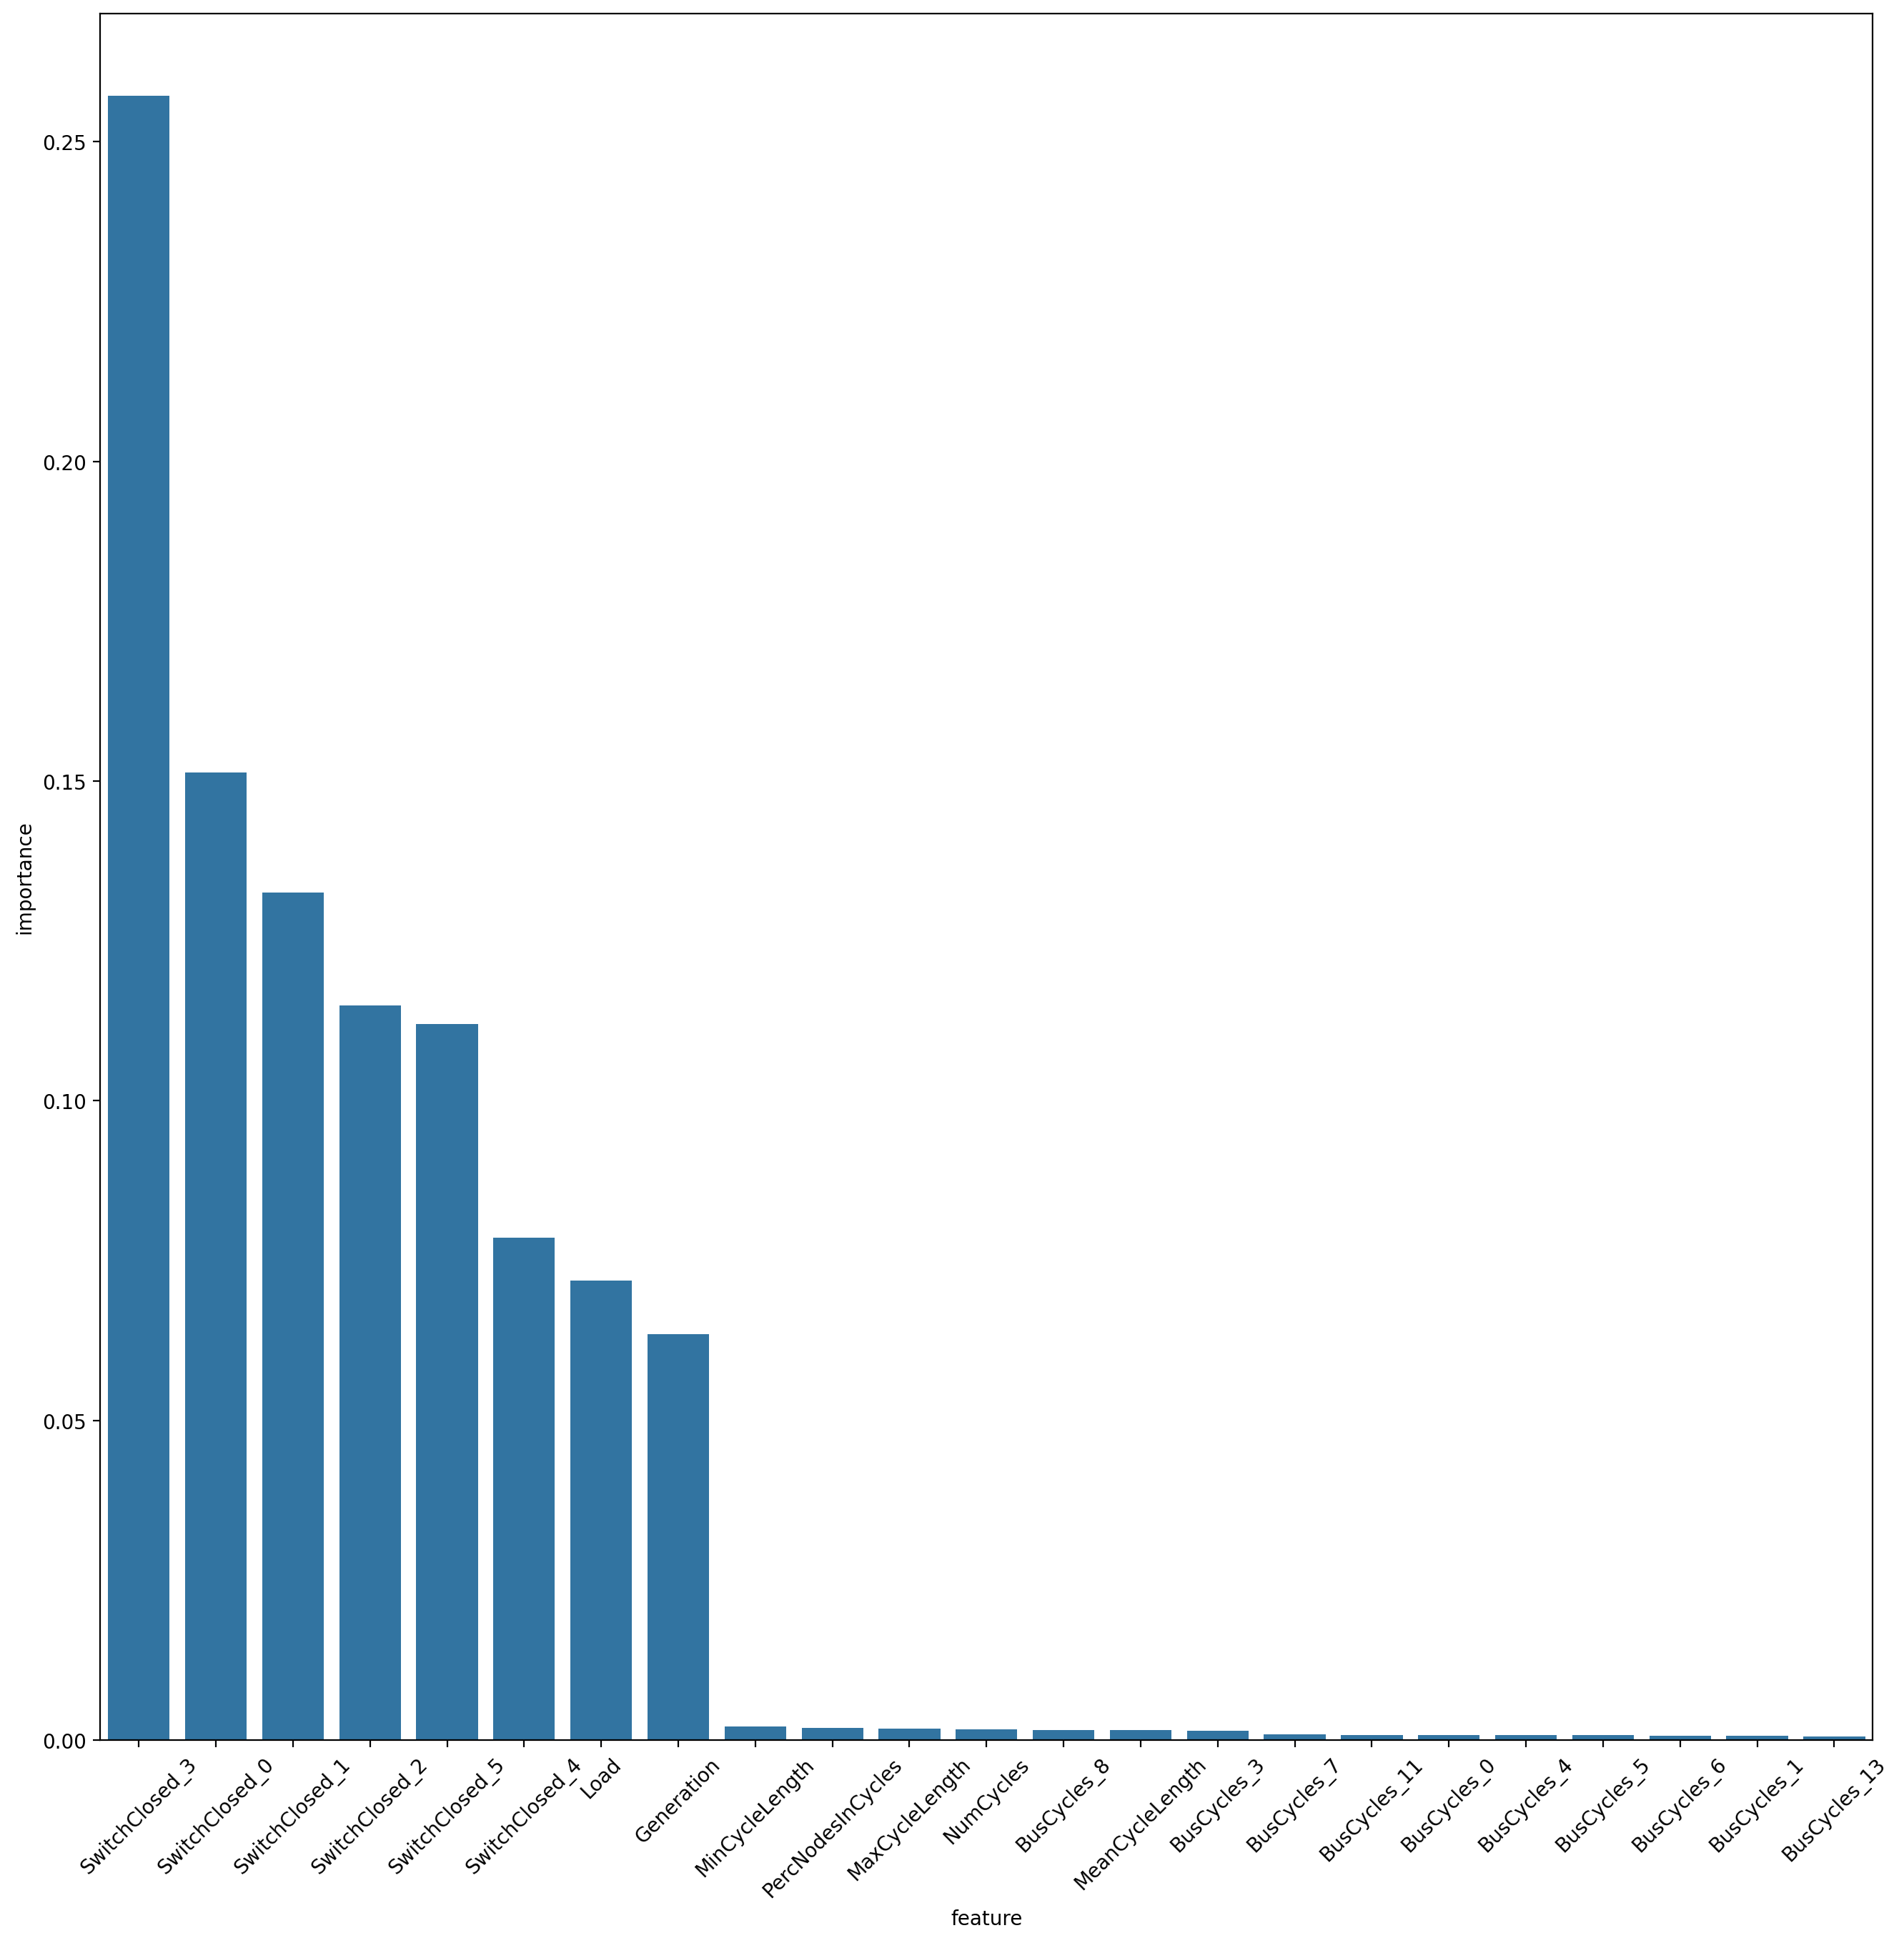

In [41]:
selFeat = pd.DataFrame(columns=["feature", "importance"])
i = 0
for selFeatIdx, col in zip(rfecv.support_, X.columns):
    if selFeatIdx:
        selFeat.loc[len(selFeat)] = {"feature": col, "importance": rfecv.estimator_.feature_importances_[i]}
        i += 1

selFeat.sort_values(by="importance", inplace=True, ascending=False)
selFeat.reset_index(inplace=True)


barPlot = sns.barplot(data=selFeat, x="feature", y="importance")
plt.xticks(rotation=45)

[-7.99999019e-04 -7.09345328e-05 -1.62762860e-06 -1.56928002e-06
 -1.73690281e-06 -1.67667361e-06 -1.84054405e-06 -1.68411821e-06
 -1.66821988e-06 -1.56316364e-06 -1.74011514e-06 -1.88615873e-06
 -1.86333179e-06 -1.71461660e-06 -1.70511206e-06 -1.72592466e-06
 -1.69460787e-06 -1.81932429e-06 -1.75937938e-06 -1.86136497e-06
 -2.04784207e-06 -1.78440895e-06 -1.77019907e-06 -1.89494676e-06
 -1.84509645e-06 -1.71162519e-06 -1.85768571e-06 -1.85584105e-06
 -1.75309340e-06 -1.75525052e-06 -1.89511182e-06]


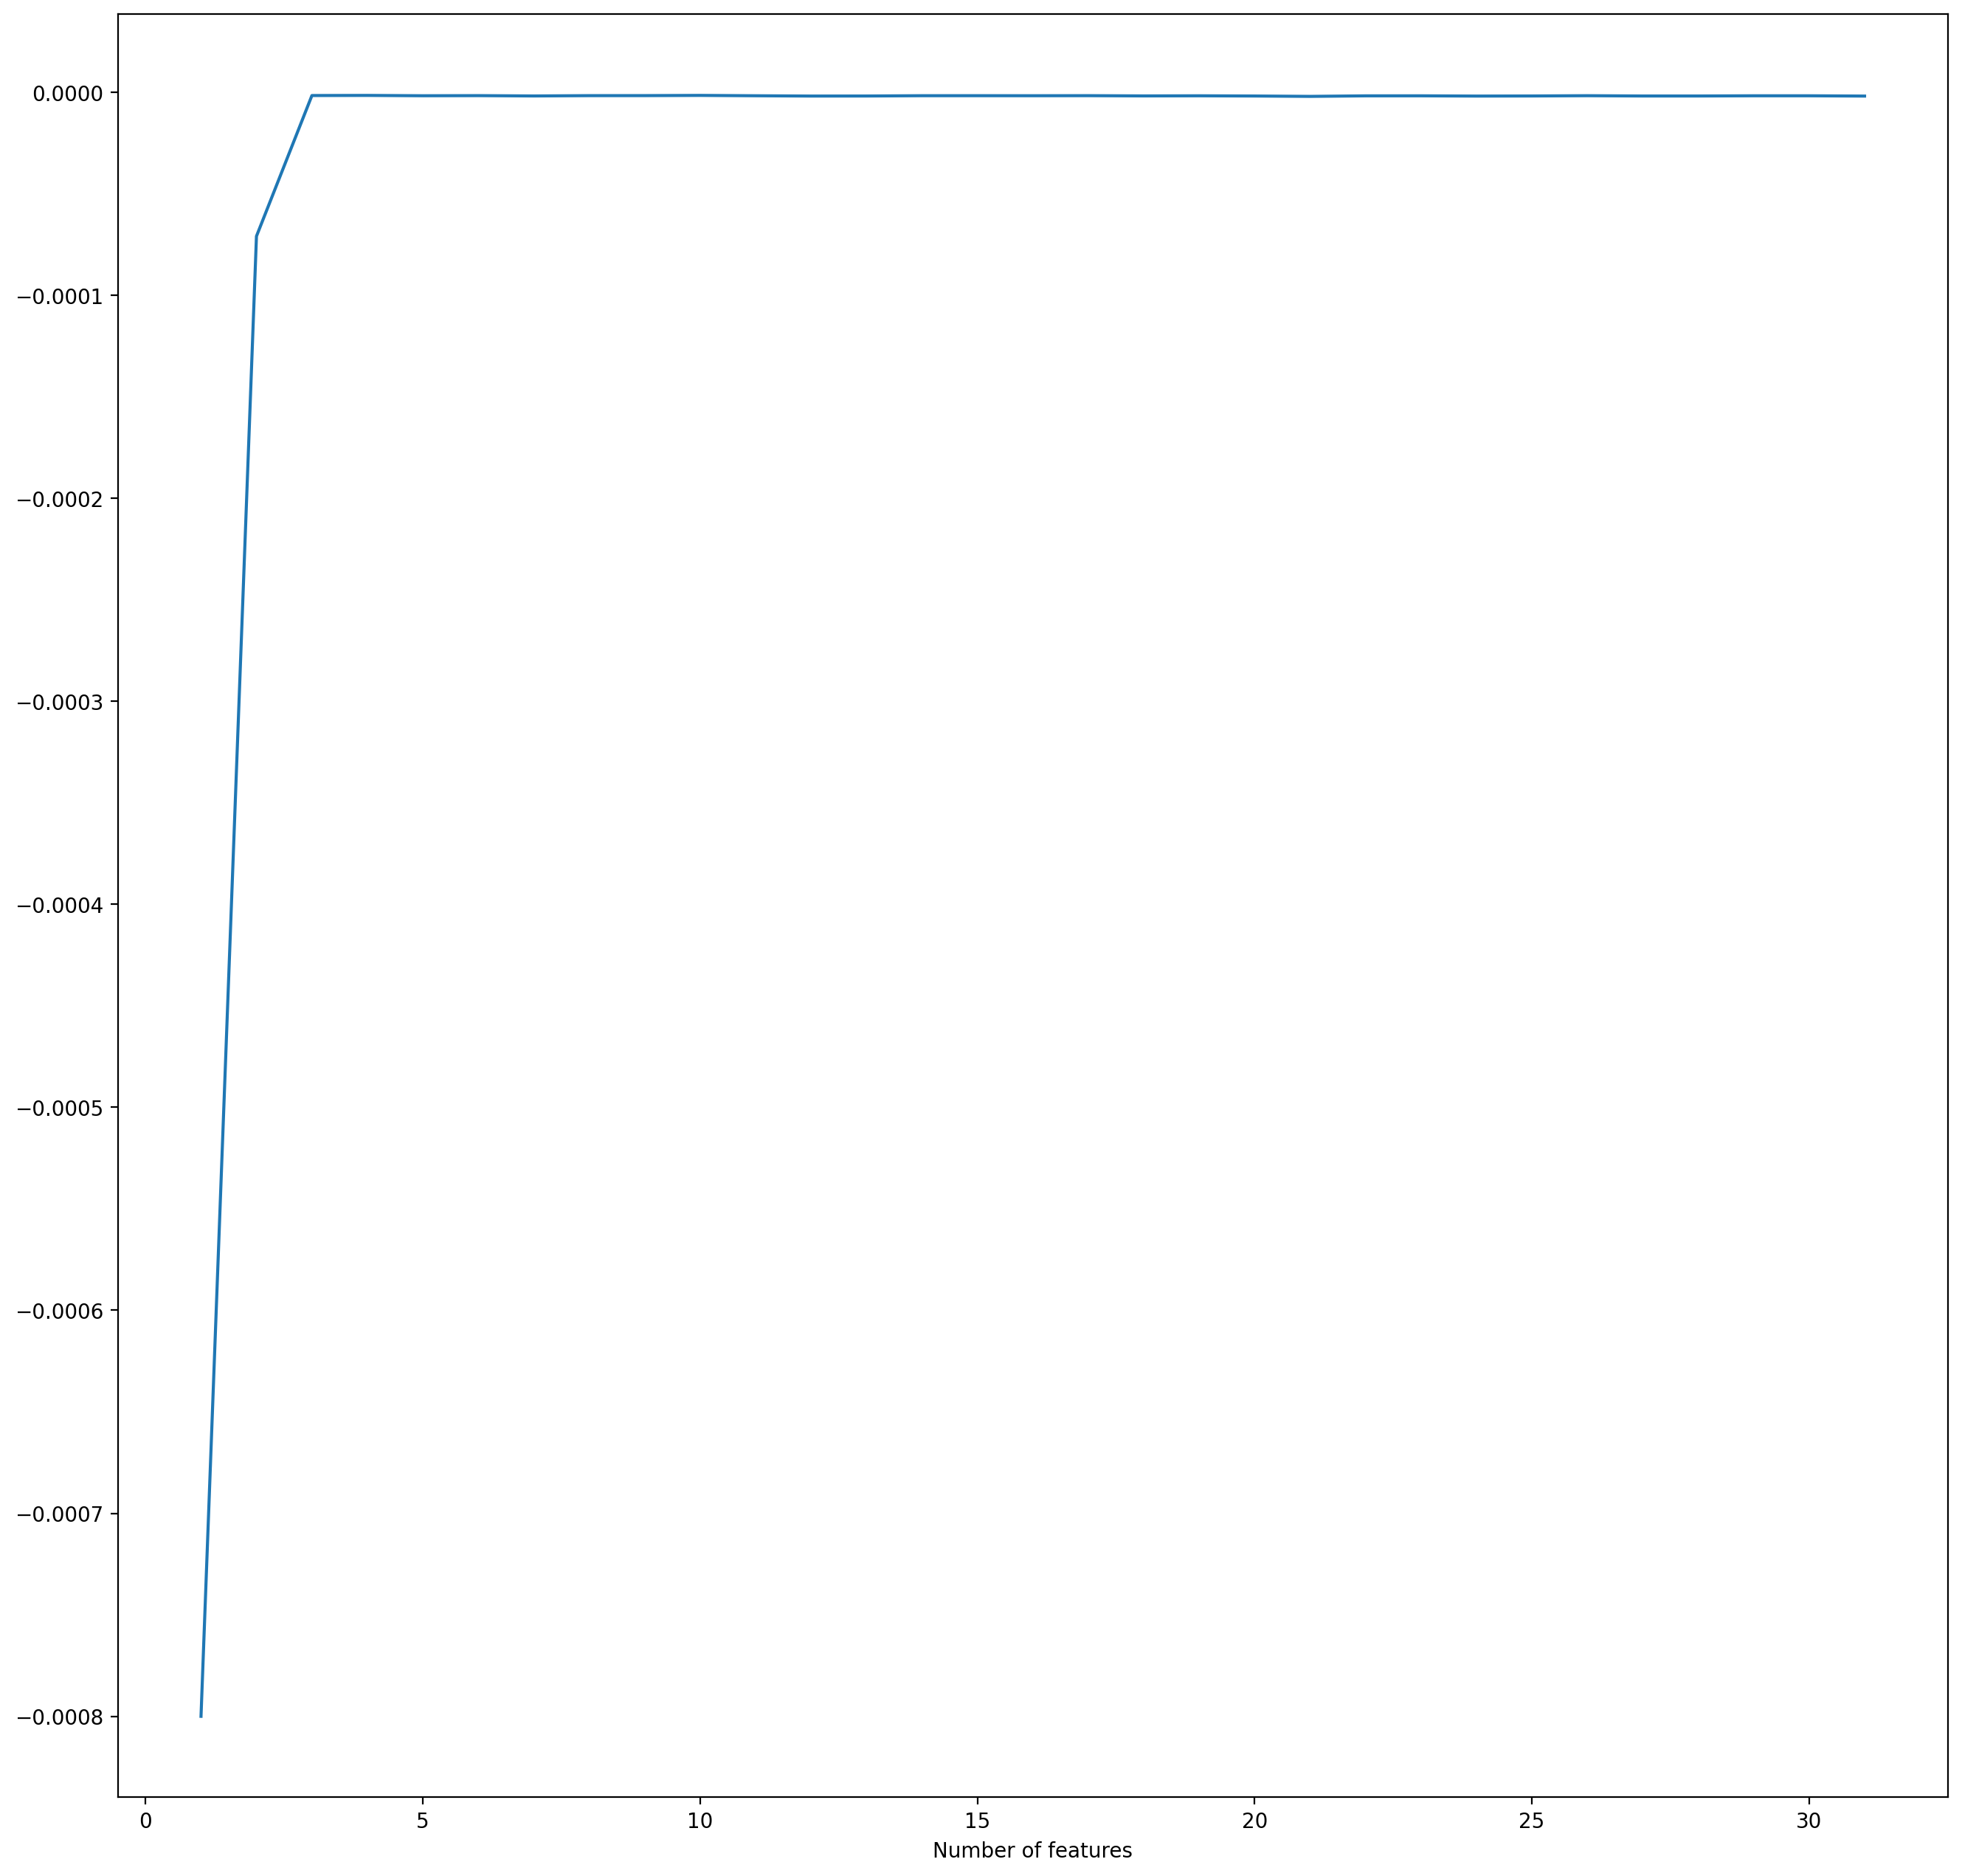

In [39]:
testScores = rfecv.cv_results_["mean_test_score"]
scoresPlot = sns.lineplot(x=rfecv.cv_results_["n_features"], y=testScores)
scoresPlot.set_xlabel("Number of features")
print(testScores)